# Influence LXe Refraction Index on the LCE

In [1]:
## Imports:

import numpy as np
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt
from matplotlib import gridspec            # to arrange the plots nicely
%matplotlib inline
import concurrent.futures

import uproot                              # uproot for easy import of ROOT tree contents
import collections                         # used for named tuples
import pandas as pd
import math
import ast
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from numpy import exp
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
import matplotlib.patches as patches
import matplotlib.cbook as cbook
from scipy.interpolate import spline
from scipy.interpolate import make_interp_spline, BSpline

In [2]:
## Function definitions:

def f_polar_R(cartesian_x, cartesian_y):
    return np.sqrt(cartesian_x * cartesian_x + cartesian_y * cartesian_y)

def f_polar_Phi(cartesian_x, cartesian_y):
    return np.arctan2(cartesian_y, cartesian_x)

def f_distance(x_a, y_a, x_b, y_b):
    return np.sqrt((x_b - x_a)**2 + (y_b - y_a)**2)


def flatten_tuples(tup):
    return np.array([element for tupl in tup for element in tupl])

def sum_tuple_subentries(tup):
    return [np.sum(tupl) for tupl in tup]

def nth_tuple_subentries(tup, n):
    return [tupl[n] for tupl in tup]


def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))


def remove_duplicate(input_list, inputcritical_list): 
    final_list = []
    finalcritical_list = []
    for i in range(0, len(inputcritical_list)): 
        if inputcritical_list[i] not in finalcritical_list: 
            finalcritical_list.append(inputcritical_list[i]) 
            final_list.append(input_list[i])
    return final_list 

In [3]:
## PMT properties and physics:

QE_PMT0 = 0.325
QE_PMT1 = 0.3
QE_PMT2 = 0.3
QE_PMT3 = 0.3
QE_PMT4 = 0.3
QE_PMT5 = 0.3
QE_PMT6 = 0.3
QE_PMT7 = 0.3
QE_Bottom = QE_PMT0
QE_Top = 0.3

CE_PMT0 = 0.95
CE_PMT1 = 0.7
CE_PMT2 = 0.7
CE_PMT3 = 0.7
CE_PMT4 = 0.7
CE_PMT5 = 0.7
CE_PMT6 = 0.7
CE_PMT7 = 0.7
CE_Bottom = CE_PMT0
CE_Top = 0.7

W = 1/(1302.808447/32.1517) # 1/W = photons/keV @ 32.1517 keV, 500 V/cm, ER
print('1/W  = '+str(1/W)+' ph/keV')
We = 1/(1045.457843/32.1517) # 1/W = electrons/keV @ 32.1517 keV, 500 V/cm, ER
print('1/We = '+str(1/We)+' e/keV')

W0 = 1/(2195.519/32.1517) # 1/W = photons/keV @ 32.1517 keV, 0.0001 V/cm, ER
print('1/W0  = '+str(1/W0)+' ph/keV')

1/W  = 40.52067066438166 ph/keV
1/We = 32.51640949001141 e/keV
1/W0  = 68.28624924965087 ph/keV


## Imports and data processing

In [4]:
## Available ROOT files in specified folder:
#! ls ../../Xebra_G4/*.root
#! ls ../../Simulation_Data/LCE/*.root
#! ls ../../Simulation_Data/Modification_Spacer_3/*.root
! ls /media/alex/TOSHIBA\ EXT/Simulation_Data/Influence_Optical_Parameters/LXeRefractionIndex/S2/*.root

'/media/alex/TOSHIBA EXT/Simulation_Data/Influence_Optical_Parameters/LXeRefractionIndex/S2/optPhot_S2_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs1000_Tmesh0.89770509_LXeRefractionIndex_1.56.root'
'/media/alex/TOSHIBA EXT/Simulation_Data/Influence_Optical_Parameters/LXeRefractionIndex/S2/optPhot_S2_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs1000_Tmesh0.89770509_LXeRefractionIndex_1.59.root'
'/media/alex/TOSHIBA EXT/Simulation_Data/Influence_Optical_Parameters/LXeRefractionIndex/S2/optPhot_S2_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs1000_Tmesh0.89770509_LXeRefractionIndex_1.63.root'
'/media/alex/TOSHIBA EXT/Simulation_Data/Influence_Optical_Parameters/LXeRefractionIndex/S2/optPhot_S2_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs1000_Tmesh0.89770509_LXeRefractionIndex_1.66.root'
'/media/alex/TOSHIBA EXT/Simulation_Data/Influence_Optical_Parameters/LXeRefractionIndex/S2/optPhot_S2_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs1000_Tmesh0.89770509_LXeRefractionIndex_1.69.root'
'/media/alex/TOSHIBA EXT/Simulation_Data/Influence_Optical_P

In [5]:
b_preprocessed = True

if b_preprocessed == False:
    
    ## Selection of path with files to be analysed
    from os import listdir
    from os.path import isfile, join
    path = "/media/alex/TOSHIBA EXT/Simulation_Data/Influence_Optical_Parameters/LXeRefractionIndex/S2"
    files = [f for f in listdir(path) if isfile(join(path, f))]
    #files = files[0:3]

    ## Initialize empty dataframe
    opticals = pd.DataFrame({'RPTFE' : [], 'LXeAbs' : [], 'LXeRefractionIndex' : [], 'LCE_b' : [],'LCE_t' : [],'LCE_a' : []})

    counter = 0
    for file in files:

        ## Selection of file to be analyzed:
        #file = "optPhot_S2_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs100.root"
        filename = path+"/"+file
        #filenameprefix = file[:-5]    
        #print(filenameprefix)

        ## Extraction of optical parameters from filename
        RPTFE = float(file[file.find("RPTFE")+5 : file.find("_", file.find("RPTFE")+5)])
        LXeAbs = float(file[file.find("LXeAbs")+6 : file.find("_", file.find("LXeAbs")+6)])
        LXeRefractionIndex = float(file[file.find("LXeRefractionIndex")+19 : file.find(".root")])

        ## Import as pandas dataframes and write to compressed dataframe
        branches= ['nbpmthits','ntpmthits'] # Be careful that the branches are also initilized in _chunk_collect
        executor = concurrent.futures.ThreadPoolExecutor(8)
        _chunk_collect = pd.DataFrame({'nbpmthits' : [],'ntpmthits' : []}) # Initialize empty data frame
        for _chunk in uproot.iterate(filename, "events/events",branches, entrysteps=100000, 
                                               outputtype=pd.DataFrame, executor=executor):
            _chunk.columns=branches
            _chunk_collect = _chunk_collect.append(_chunk)
        LCE_b = _chunk_collect["nbpmthits"].mean()
        LCE_t = _chunk_collect["ntpmthits"].mean()
        LCE_a = LCE_b + LCE_t
        opticals = opticals.append(pd.DataFrame({'RPTFE' : [RPTFE], 'LXeAbs' : [LXeAbs], 'LXeRefractionIndex' : [LXeRefractionIndex], 'LCE_b' : [LCE_b],'LCE_t' : [LCE_t],'LCE_a' : [LCE_a]}), ignore_index=True)
        del(_chunk)
        del(_chunk_collect)
        
        counter += 1
        print(str(round(100*counter / len(files),1))+'%', end = ' ')

    ## Derive DE and LY
    opticals['DE_b'] = opticals['LCE_b'] * QE_Bottom * CE_Bottom
    opticals['DE_t'] = opticals['LCE_t'] * QE_Top * CE_Top
    opticals['DE_a'] = opticals['DE_b'] + opticals['DE_t']
    opticals['LY_b'] = opticals['DE_b']/W
    opticals['LY_t'] = opticals['DE_t']/W
    opticals['LY_a'] = opticals['LY_b'] + opticals['LY_t']
    opticals['LY0_b'] = opticals['DE_b']/W0
    opticals['LY0_t'] = opticals['DE_t']/W0
    opticals['LY0_a'] = opticals['LY0_b'] + opticals['LY0_t']

    ## Save to pickle file
    opticals.to_pickle("Influence_LXeRefractionIndex_S2.pkl")

if b_preprocessed == True:
    opticals = pd.read_pickle("proc/Influence_LXeRefractionIndex_S2.pkl")

print('Done.')
opticals

5.0% 10.0% 15.0% 20.0% 25.0% 30.0% 35.0% 40.0% 45.0% 50.0% 55.0% 60.0% 65.0% 70.0% 75.0% 80.0% 85.0% 90.0% 95.0% 100.0% Done.


RPTFE  LXeAbs  LXeRefractionIndex     LCE_b     LCE_t     LCE_a      DE_b  \
0    0.95   100.0                1.66  0.140413  0.129136  0.269549  0.043353   
1    0.95  1000.0                1.56  0.161665  0.133158  0.294823  0.049914   
2    0.95  1000.0                1.59  0.160921  0.132952  0.293873  0.049684   
3    0.95  1000.0                1.63  0.161801  0.131947  0.293749  0.049956   
4    0.95  1000.0                1.66  0.163632  0.131064  0.294696  0.050521   
5    0.95  1000.0                1.69  0.165008  0.130190  0.295198  0.050946   
6    0.95   100.0                1.56  0.138815  0.130891  0.269706  0.042859   
7    0.95   100.0                1.59  0.138348  0.130819  0.269167  0.042715   
8    0.95   100.0                1.63  0.138863  0.129774  0.268637  0.042874   
9    0.95   100.0                1.69  0.141226  0.128416  0.269641  0.043603   
10   0.99  1000.0                1.56  0.184357  0.141597  0.325954  0.056920   
11   0.99  1000.0                1.59  0.182172  0.140955  0.323128  0.056246   
12   0.99  1000.0                1.63  0.181734  0.139545  0.321280  0.056110   
13   0.99  1000.0                1.66  0.183971  0.138442  0.322412  0.056801   
14   0.99  1000.0                1.69  0.185448  0.137696  0.323144  0.057257   
15   0.99   100.0                1.56  0.156015  0.138370  0.294385  0.048170   
16   0.99   100.0                1.59  0.154754  0.138058  0.292812  0.047780   
17   0.99   100.0                1.63  0.154638  0.137051  0.291689  0.047744   
18   0.99   100.0                1.66  0.156129  0.135977  0.292106  0.048205   
19   0.99   100.0                1.69  0.156223  0.135382  0.291605  0.048234   

        DE_t      DE_a      LY_b      LY_t      LY_a     LY0_b     LY0_t  \
0   0.027119  0.070471  1.756674  1.098863  2.855537  2.960383  1.851826   
1   0.027963  0.077877  2.022553  1.133086  3.155639  3.408447  1.909499   
2   0.027920  0.077604  2.013239  1.131336  3.144575  3.392750  1.906551   
3   0.027709  0.077665  2.024258  1.122785  3.147043  3.411320  1.892139   
4   0.027523  0.078045  2.047163  1.115270  3.162433  3.449920  1.879475   
5   0.027340  0.078286  2.064369  1.107832  3.172201  3.478916  1.866941   
6   0.027487  0.070346  1.736681  1.113794  2.850475  2.926689  1.876989   
7   0.027472  0.070187  1.730836  1.113186  2.844022  2.916839  1.875963   
8   0.027252  0.070126  1.737283  1.104289  2.841572  2.927703  1.860971   
9   0.026967  0.070571  1.766838  1.092732  2.859570  2.977511  1.841494   
10  0.029735  0.086656  2.306443  1.204897  3.511340  3.886864  2.030517   
11  0.029601  0.085846  2.279113  1.199438  3.478551  3.840808  2.021316   
12  0.029305  0.085415  2.273635  1.187439  3.461073  3.831575  2.001095   
13  0.029073  0.085874  2.301613  1.178048  3.479660  3.878724  1.985270   
14  0.028916  0.086173  2.320096  1.171701  3.491797  3.909873  1.974575   
15  0.029058  0.077227  1.951870  1.177439  3.129309  3.289330  1.984244   
16  0.028992  0.076772  1.936086  1.174785  3.110871  3.262731  1.979772   
17  0.028781  0.076525  1.934636  1.166216  3.100852  3.260287  1.965331   
18  0.028555  0.076760  1.953292  1.157071  3.110363  3.291727  1.949920   
19  0.028430  0.076664  1.954472  1.152009  3.106481  3.293715  1.941389   

       LY0_a  
0   4.812209  
1   5.317946  
2   5.299301  
3   5.303459  
4   5.329395  
5   5.345856  
6   4.803678  
7   4.792803  
8   4.788674  
9   4.819005  
10  5.917381  
11  5.862124  
12  5.832671  
13  5.863994  
14  5.884447  
15  5.273574  
16  5.242503  
17  5.225618  
18  5.241647  
19  5.235104

In [6]:
plt.rcParams['axes.axisbelow'] = True

## Evaluation

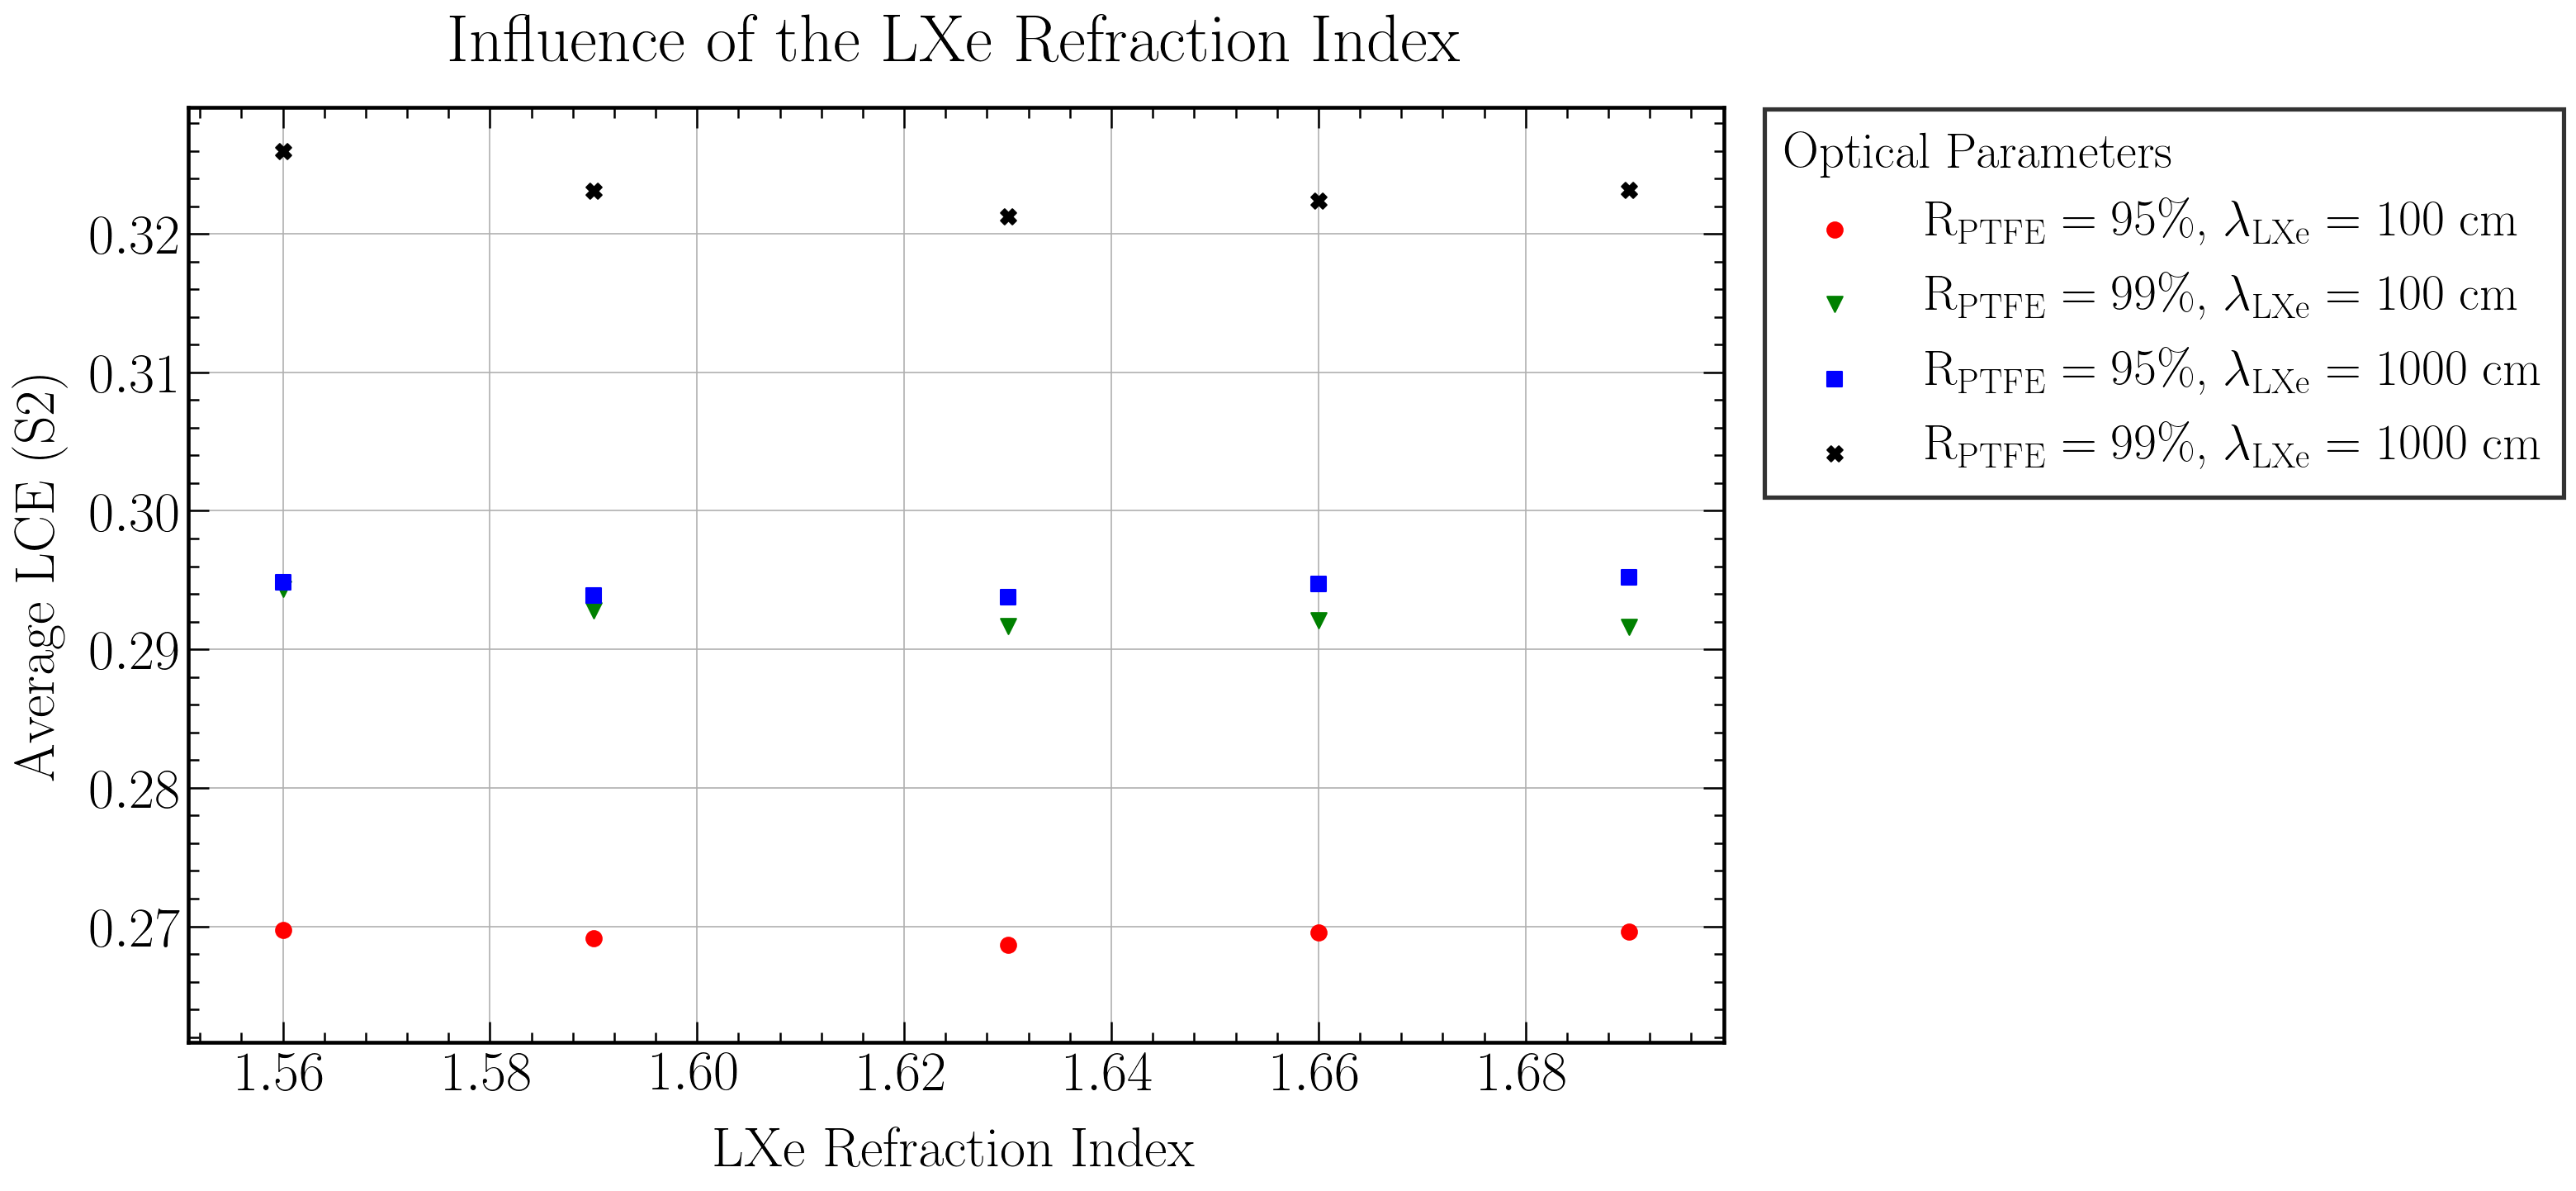

In [7]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LCE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LCE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LCE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LCE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

plt.xlabel('LXe Refraction Index', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LCE (S2)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Refraction Index', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRefractionIndex_LCE_S2.png", bbox_inches='tight')
plt.show()

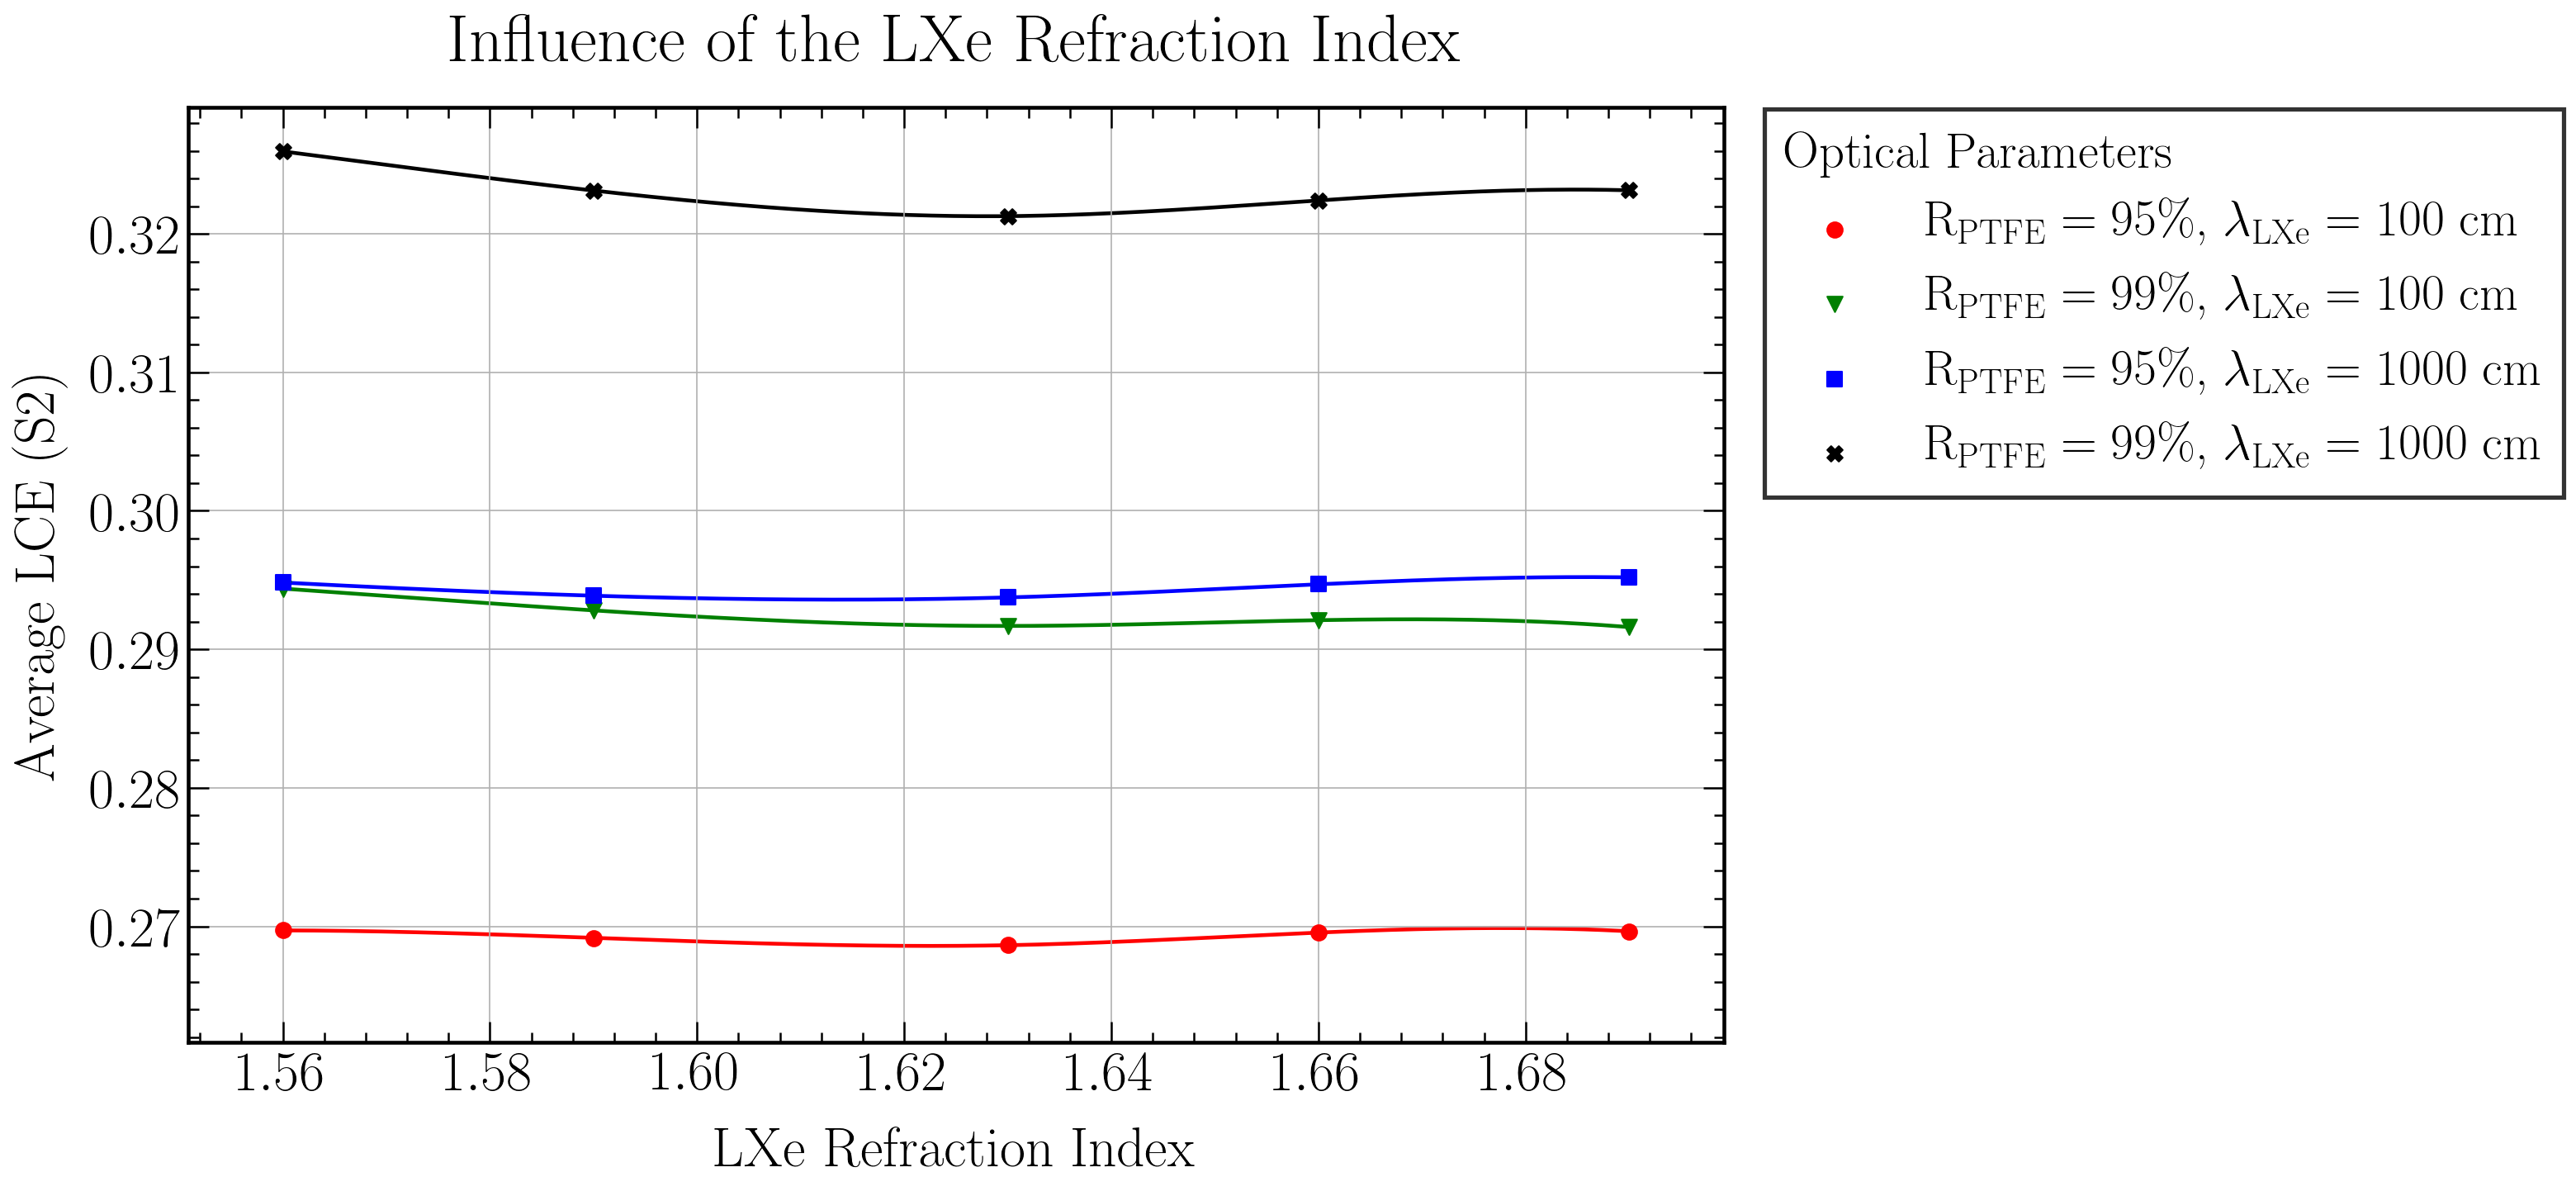

In [8]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LCE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'red', zorder=0)

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LCE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'green', zorder=0)

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LCE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'blue', zorder=0)

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LCE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'black', zorder=0)

plt.xlabel('LXe Refraction Index', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LCE (S2)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Refraction Index', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRefractionIndex_LCE_spline_S2.png", bbox_inches='tight')
plt.show()

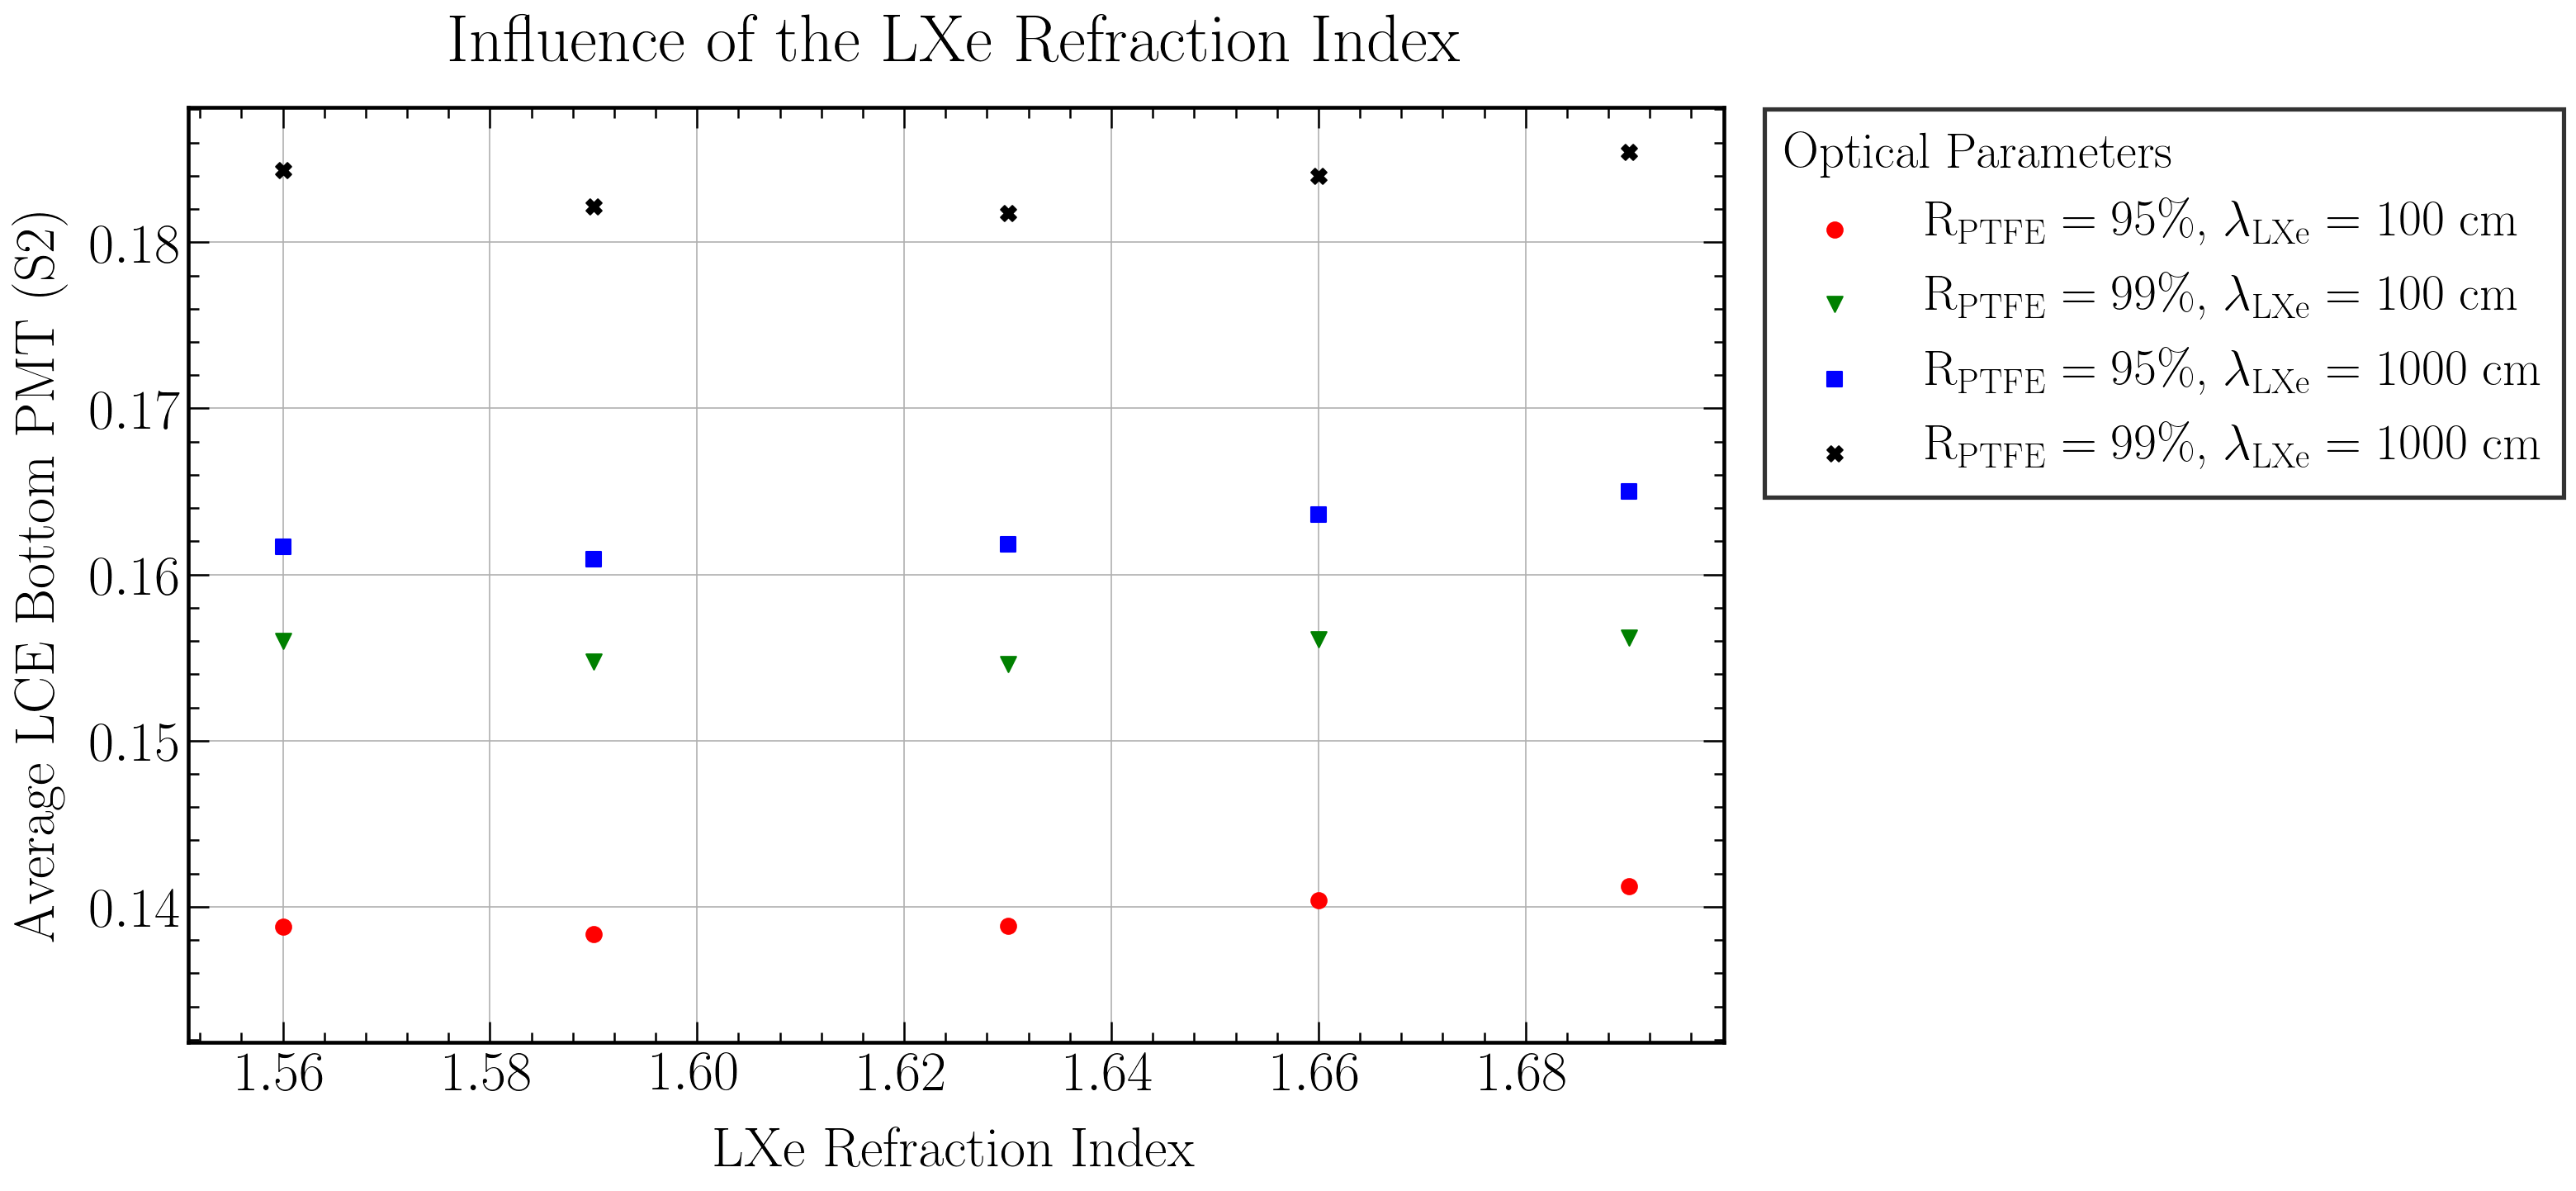

In [9]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LCE_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LCE_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LCE_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LCE_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

plt.xlabel('LXe Refraction Index', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LCE Bottom PMT (S2)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Refraction Index', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRefractionIndex_LCE_Bottom_S2.png", bbox_inches='tight')
plt.show()

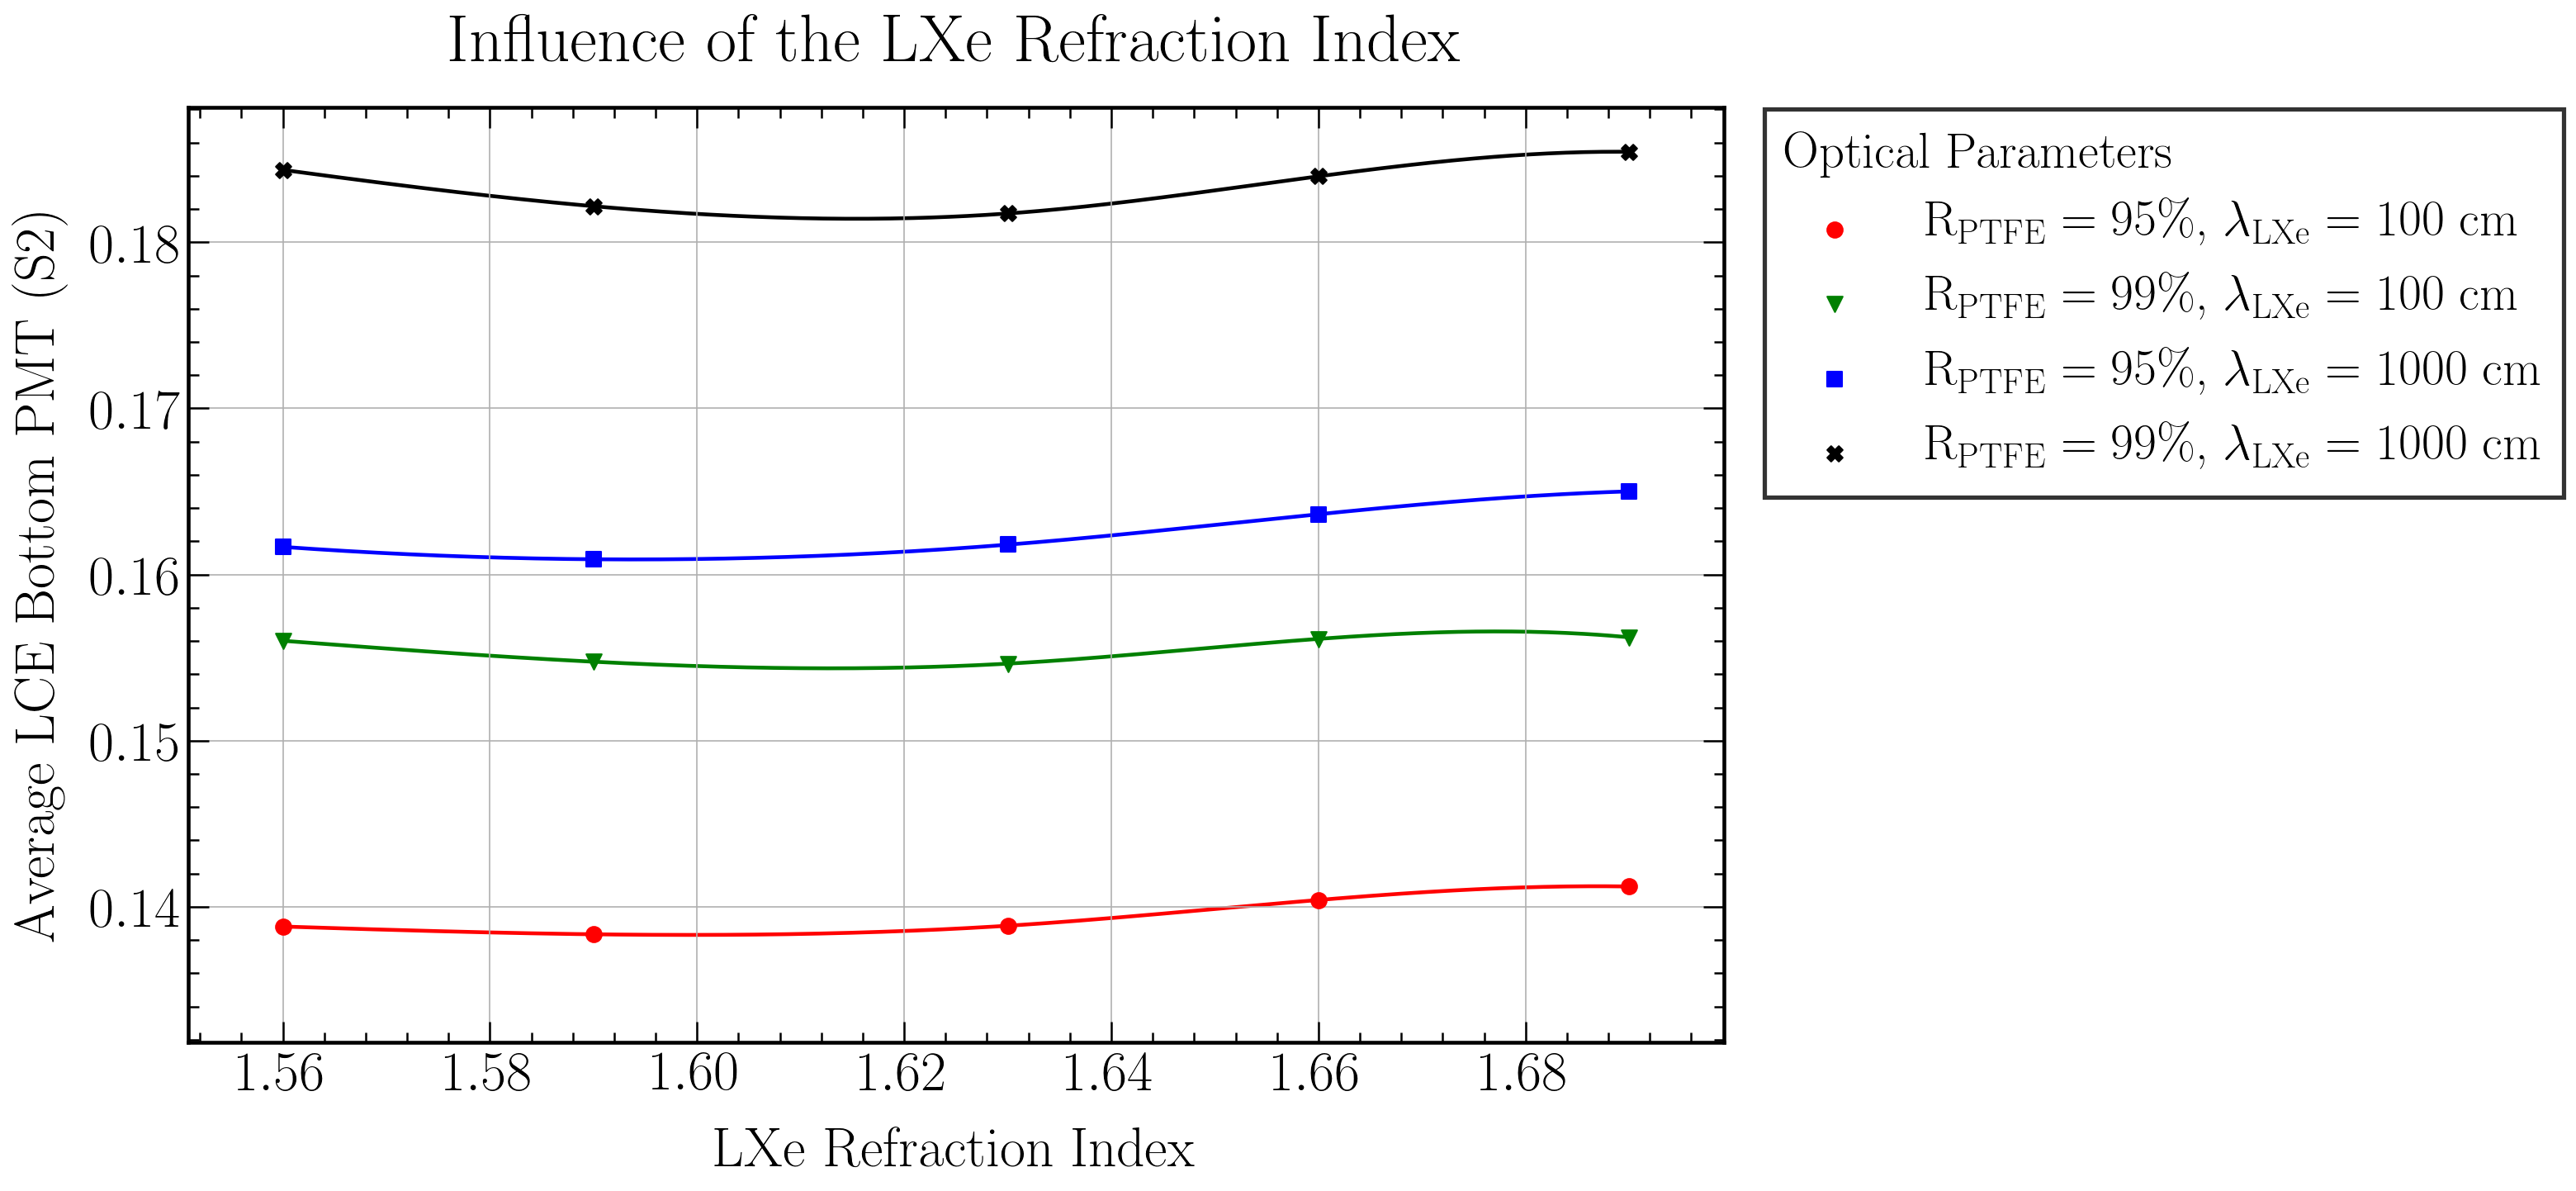

In [10]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LCE_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'red', zorder=0)

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LCE_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'green', zorder=0)

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LCE_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'blue', zorder=0)

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LCE_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'black', zorder=0)

plt.xlabel('LXe Refraction Index', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LCE Bottom PMT (S2)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Refraction Index', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRefractionIndex_LCE_Bottom_spline_S2.png", bbox_inches='tight')
plt.show()

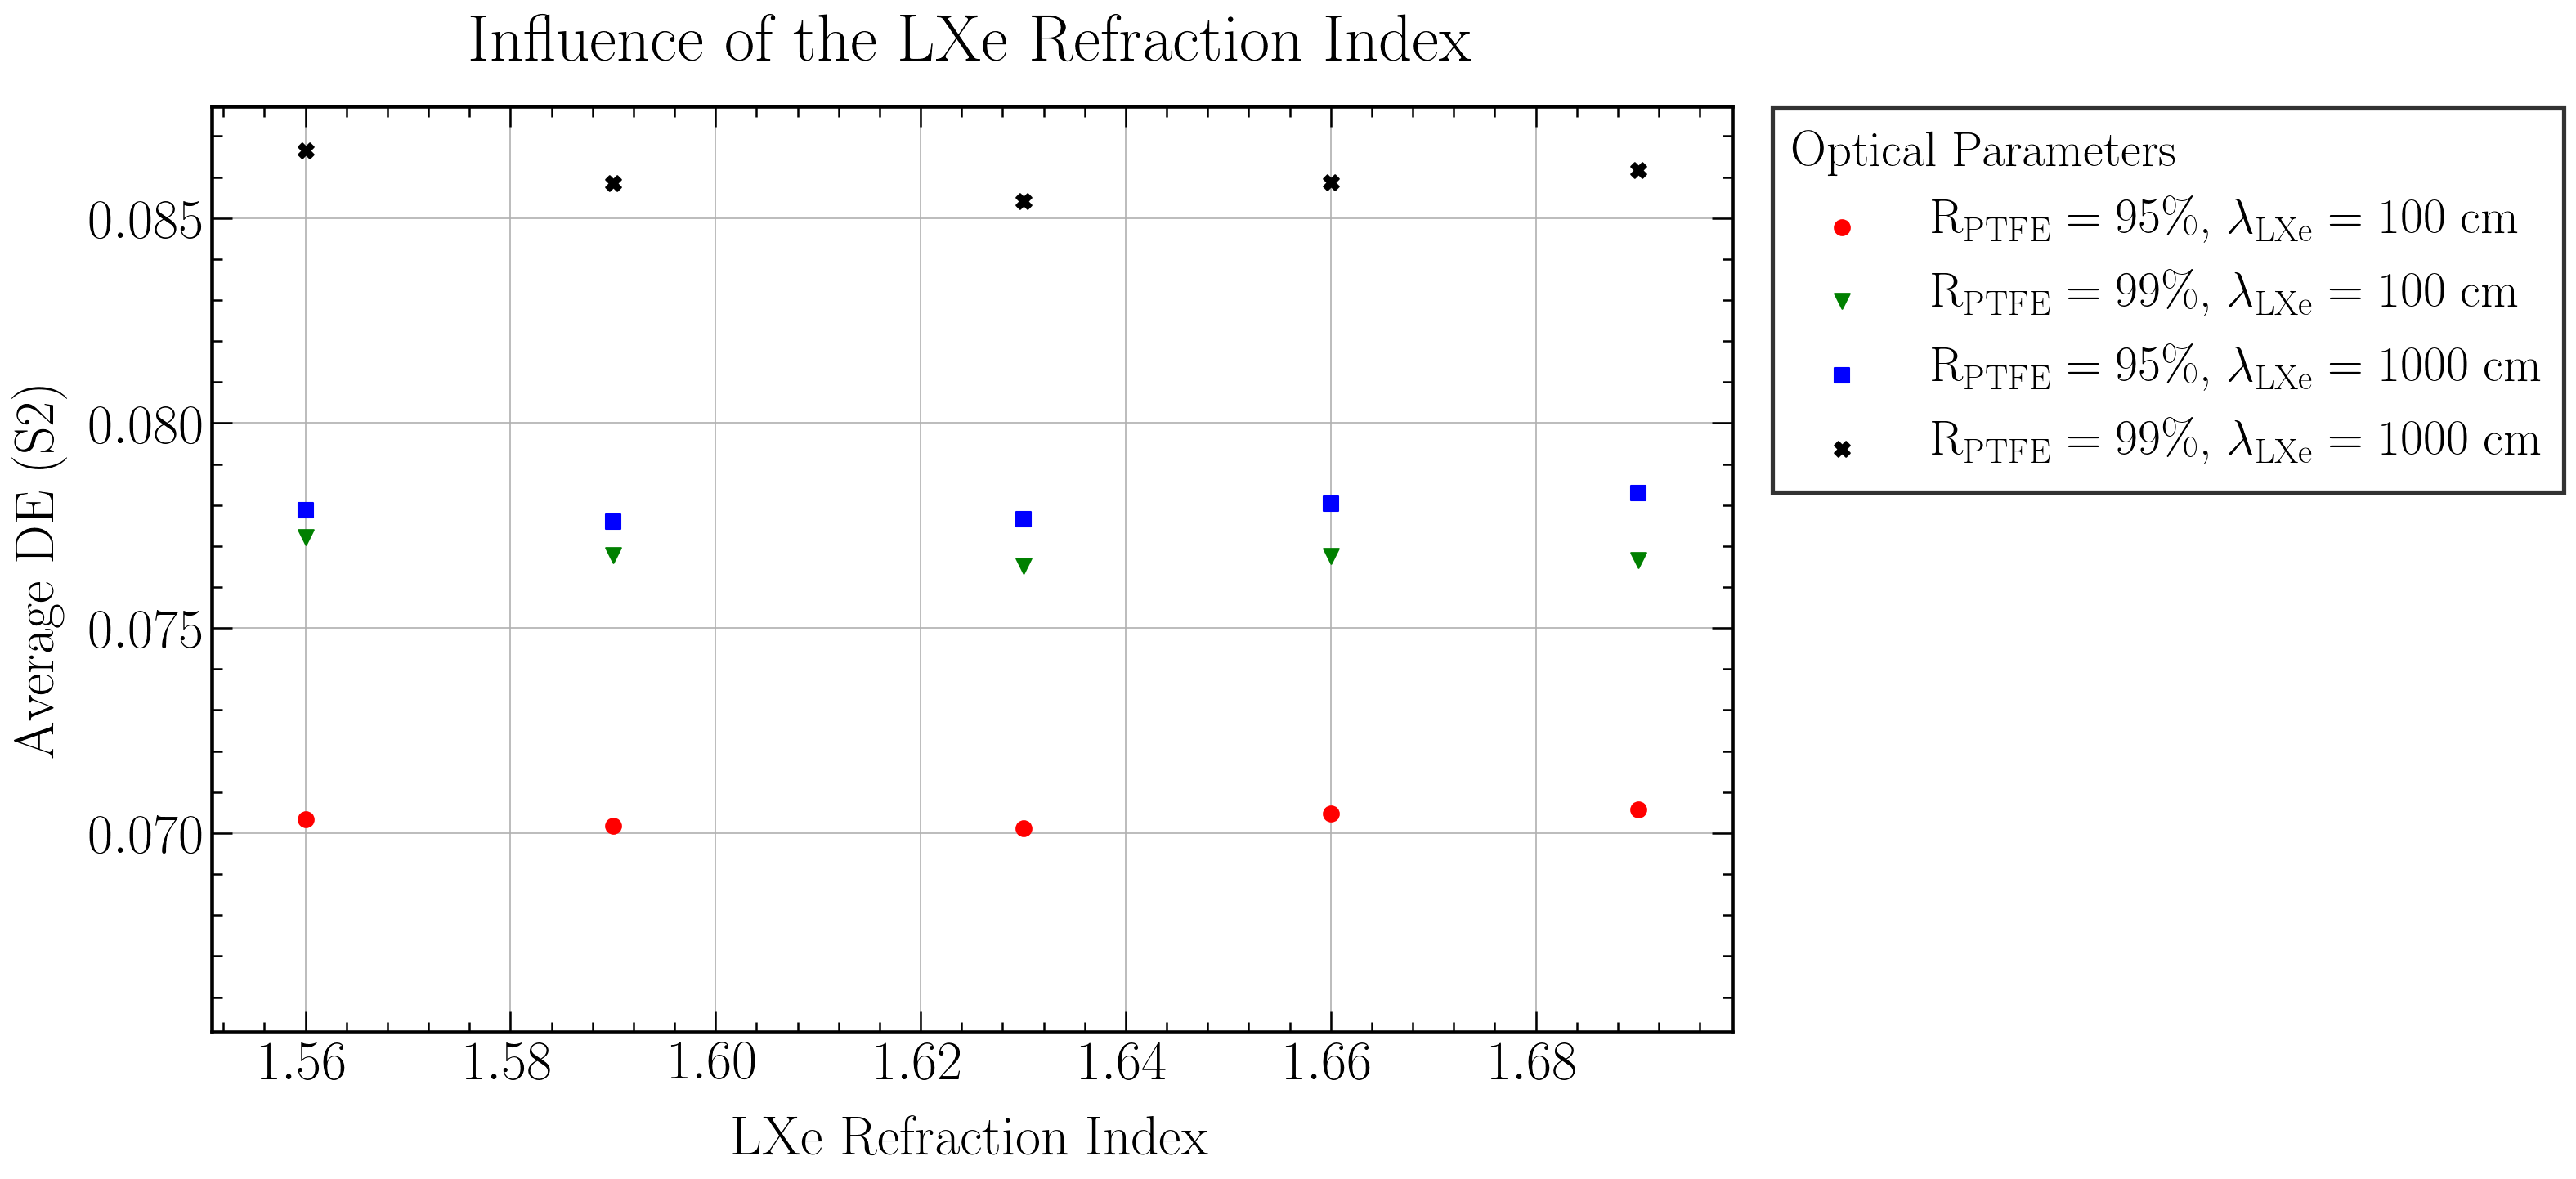

In [11]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["DE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["DE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["DE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["DE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

plt.xlabel('LXe Refraction Index', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average DE (S2)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Refraction Index', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRefractionIndex_DE_S2.png", bbox_inches='tight')
plt.show()

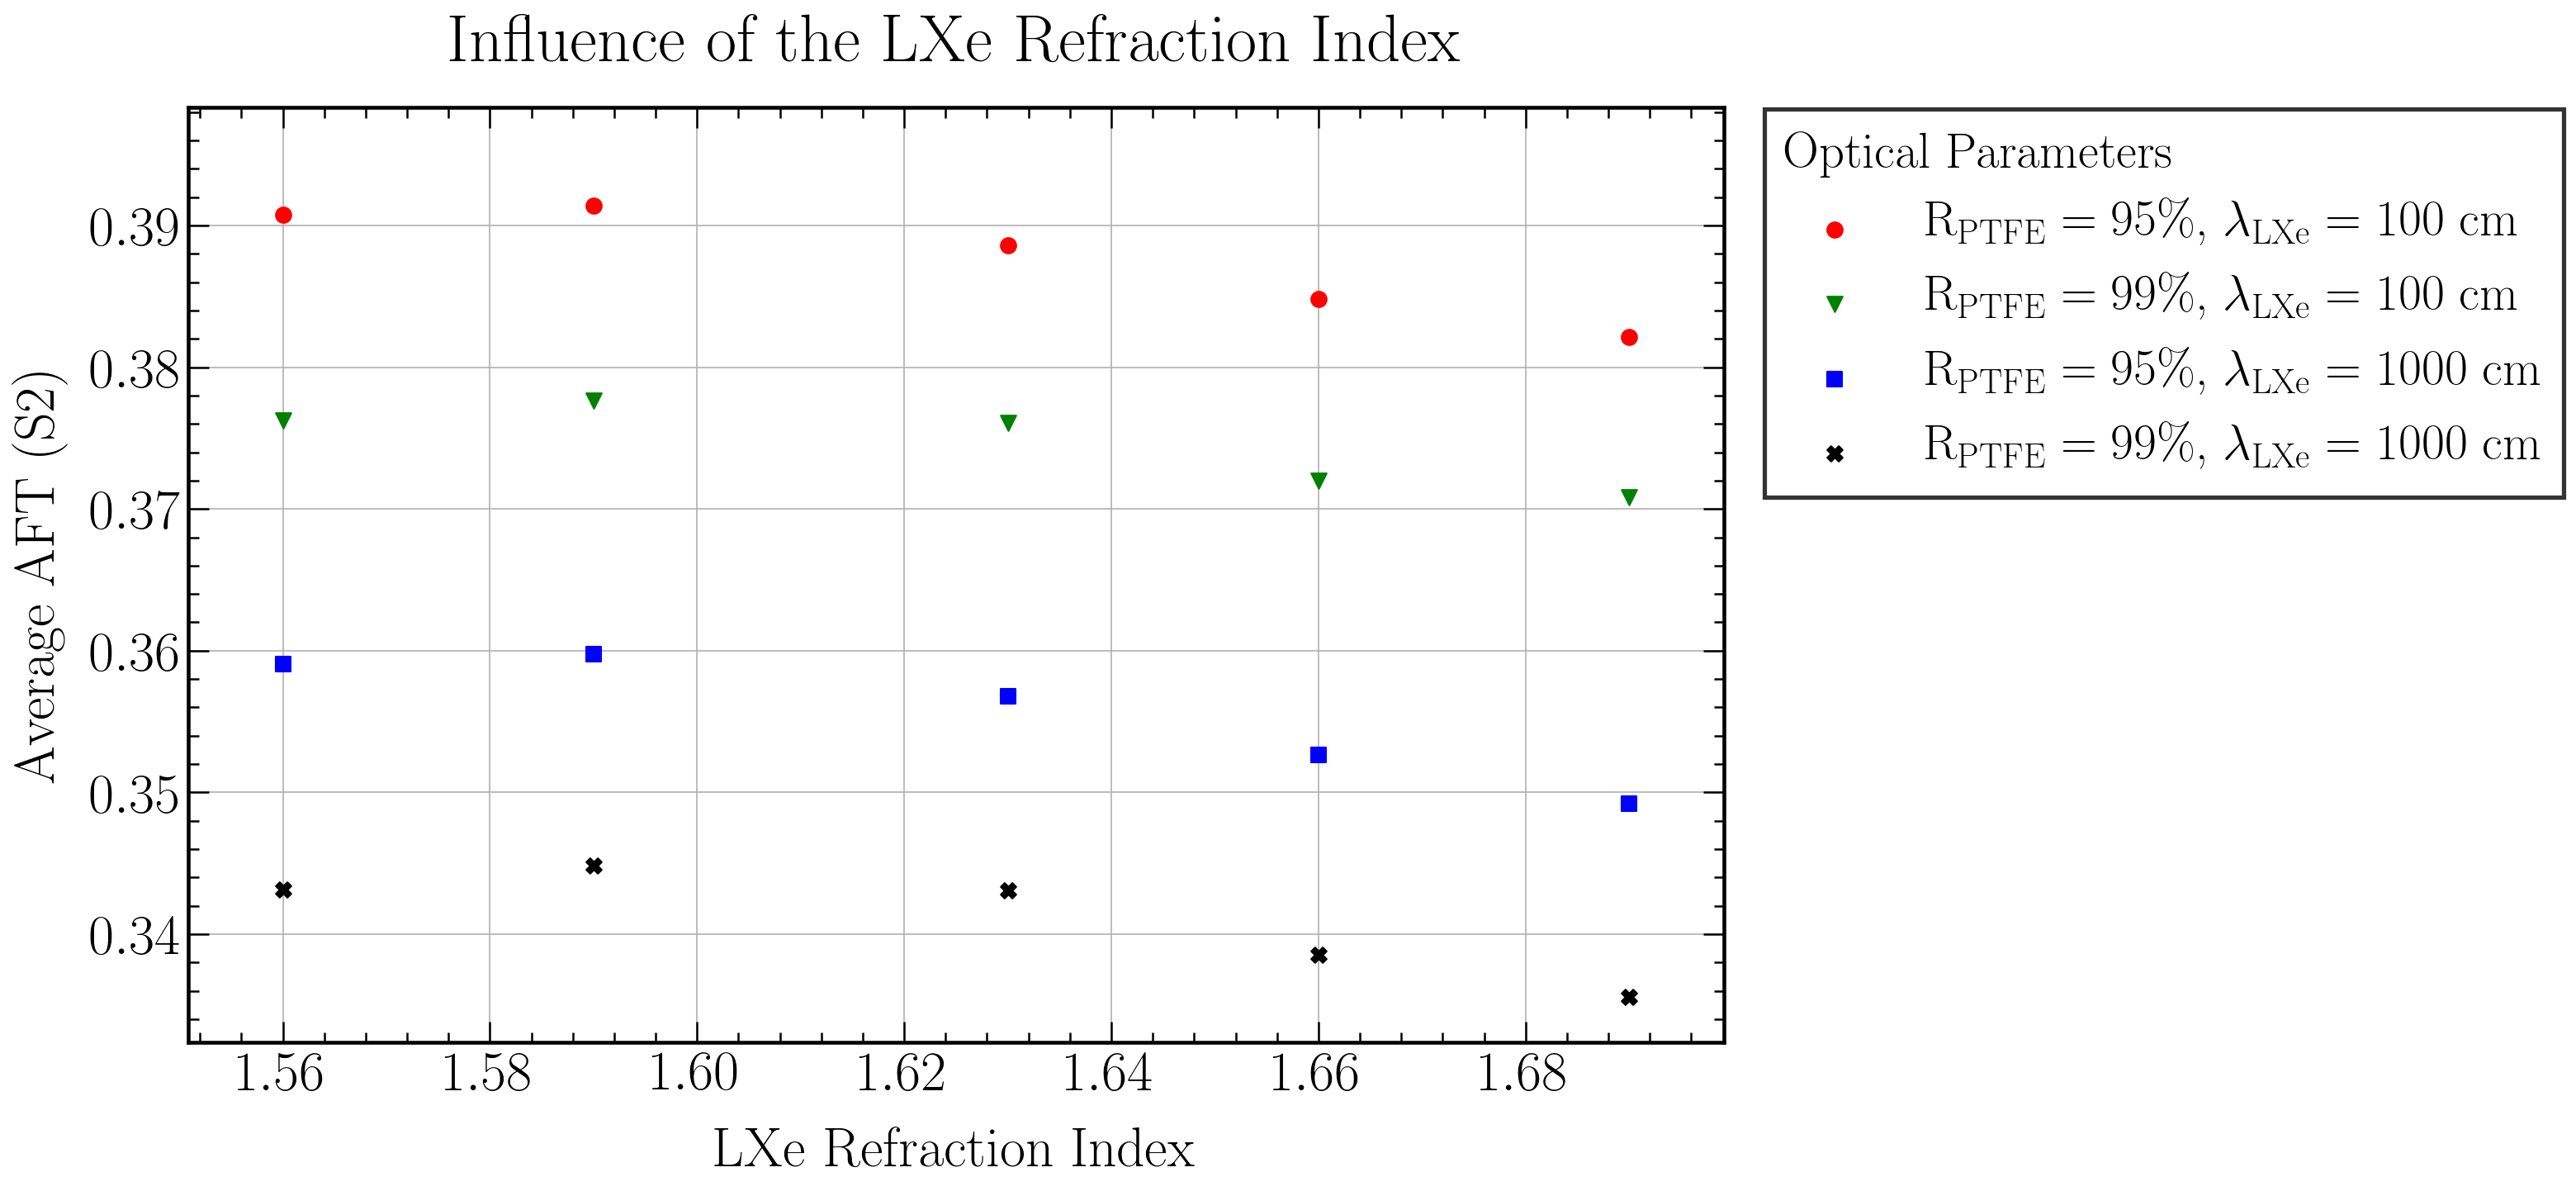

In [12]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

plt.xlabel('LXe Refraction Index', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average AFT (S2)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Refraction Index', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRefractionIndex_AFT_S2.png", bbox_inches='tight')
plt.show()

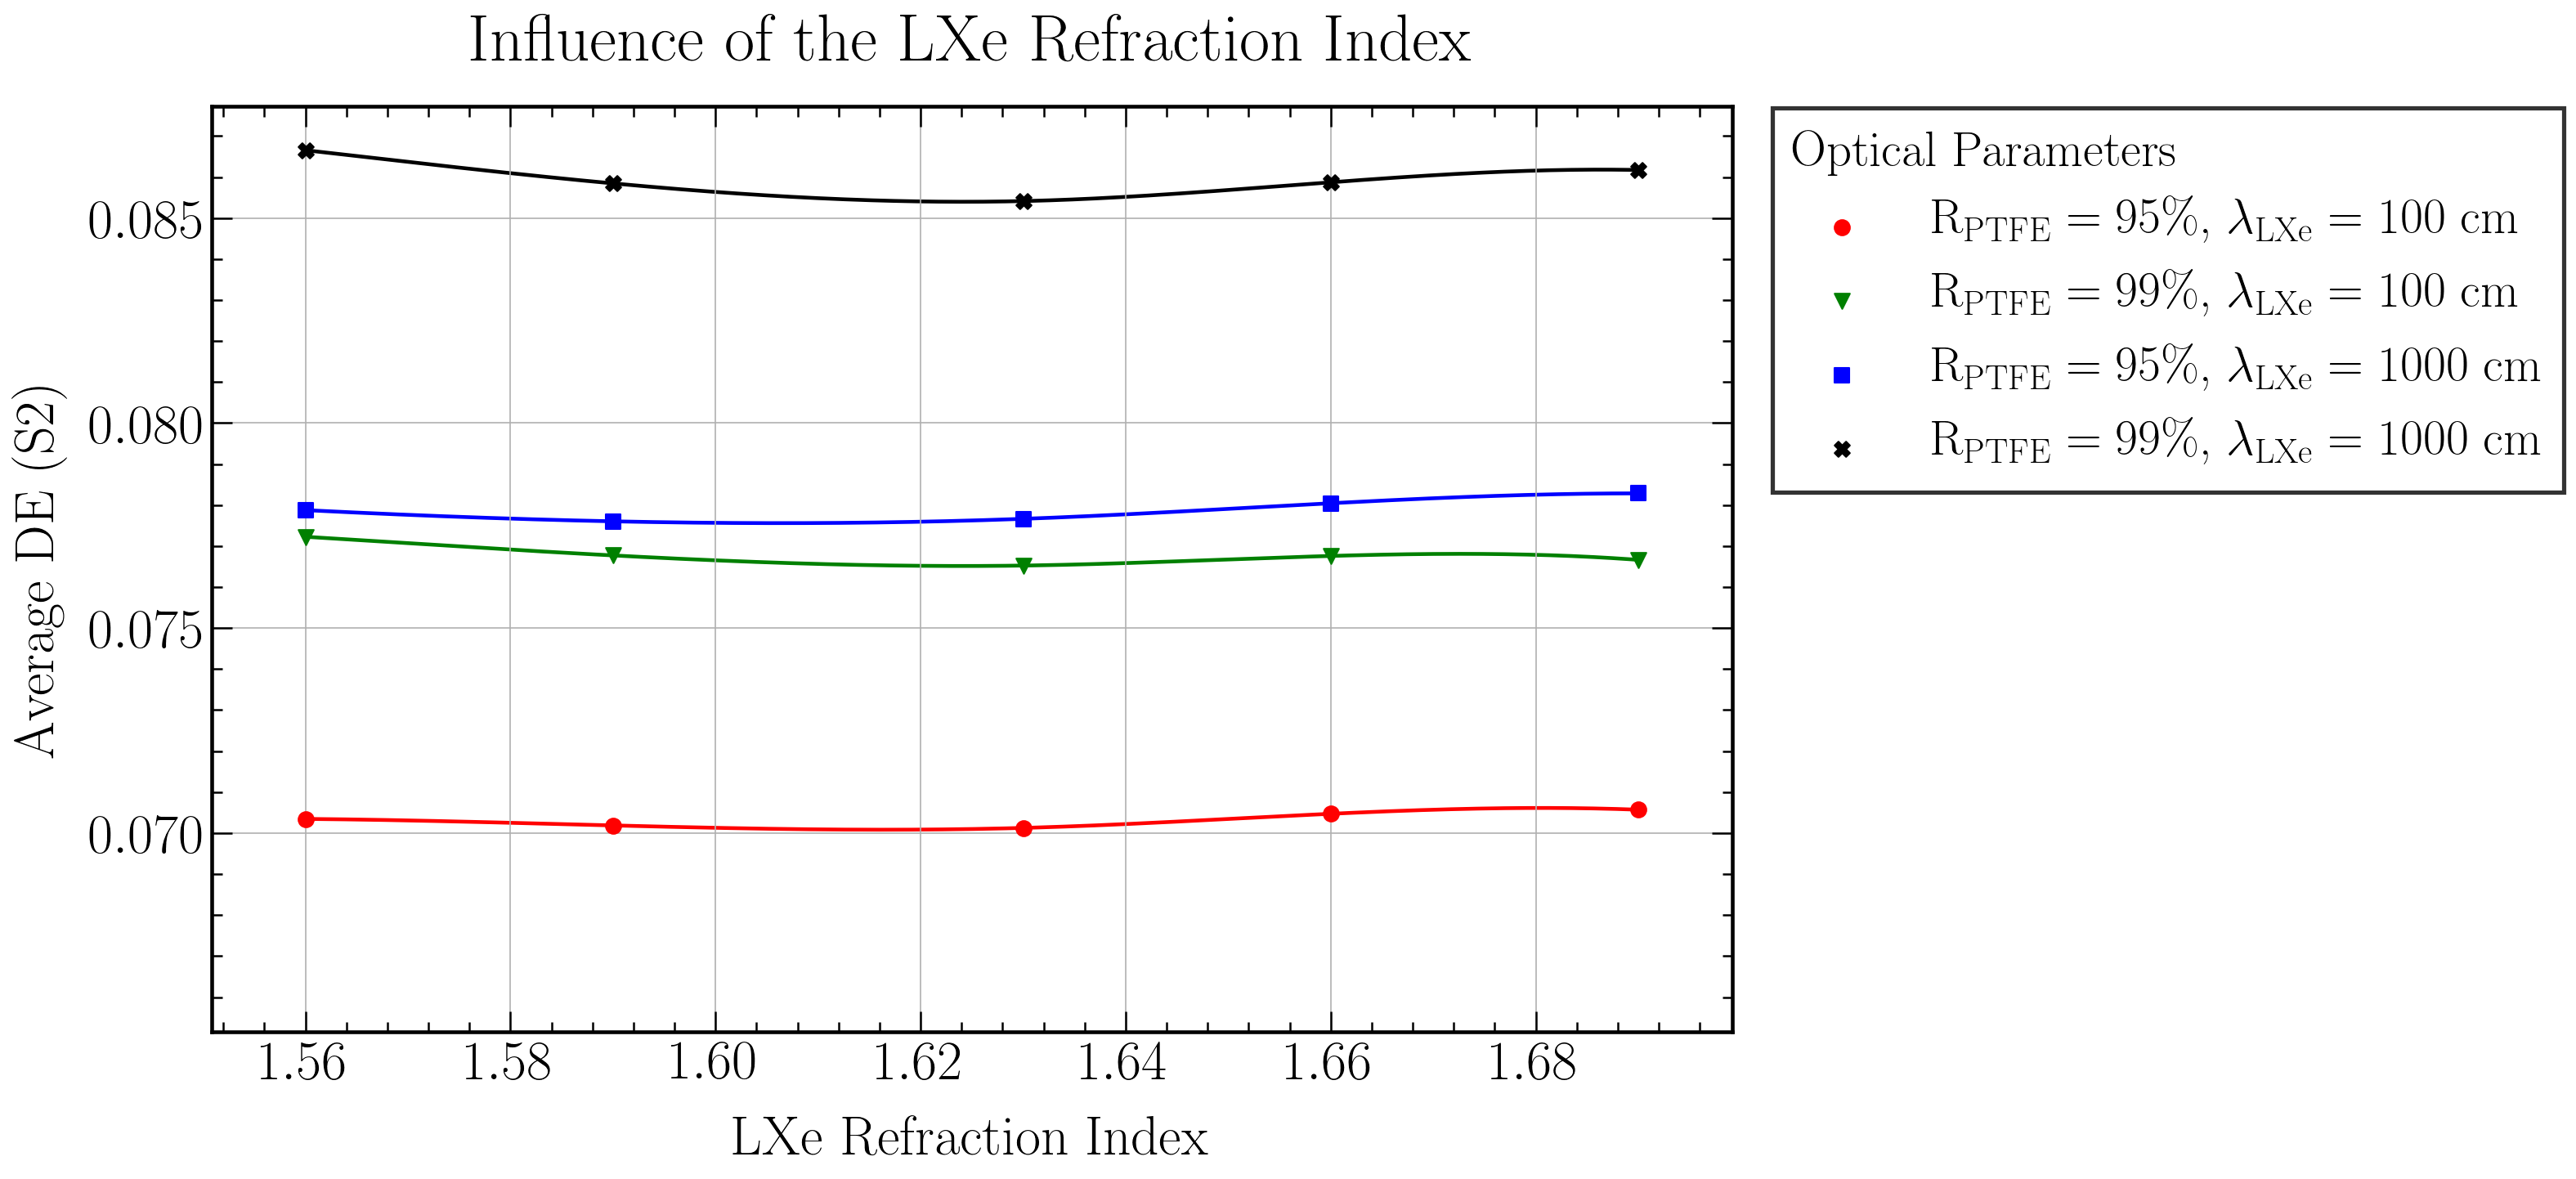

In [13]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["DE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'red', zorder=0)

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["DE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'green', zorder=0)

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["DE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'blue', zorder=0)

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["DE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'black', zorder=0)

plt.xlabel('LXe Refraction Index', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average DE (S2)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Refraction Index', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRefractionIndex_DE_spline_S2.png", bbox_inches='tight')
plt.show()

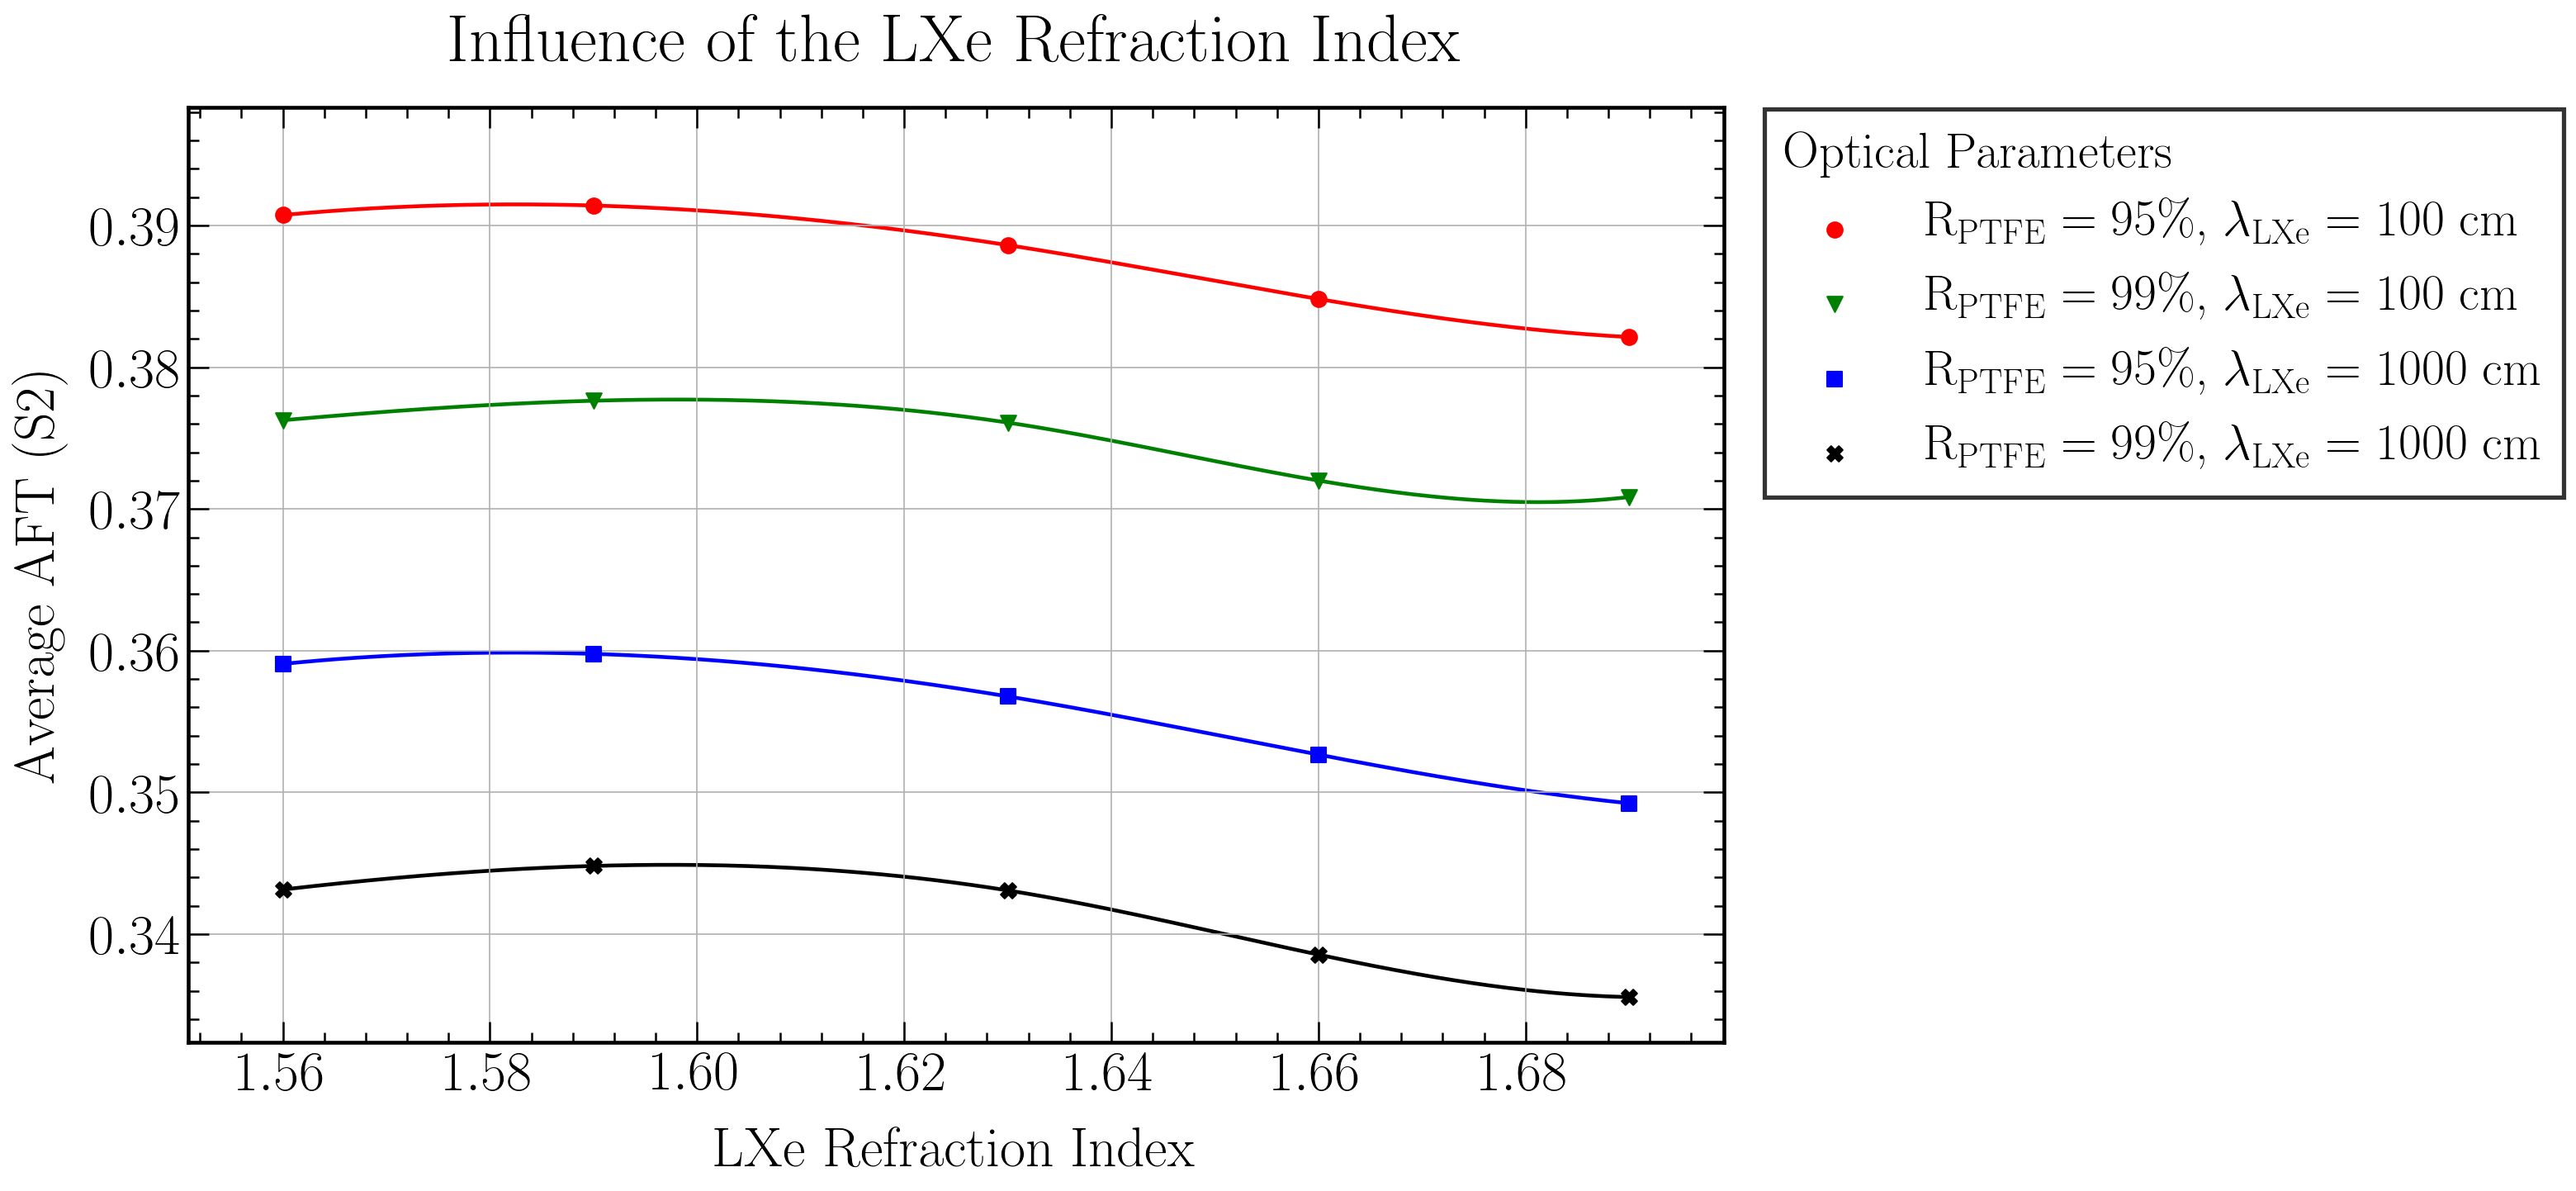

In [14]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'red', zorder=0)


x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'green', zorder=0)


x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'blue', zorder=0)


x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'black', zorder=0)


plt.xlabel('LXe Refraction Index', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average AFT (S2)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Refraction Index', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRefractionIndex_AFT_spline_S2.png", bbox_inches='tight')
plt.show()

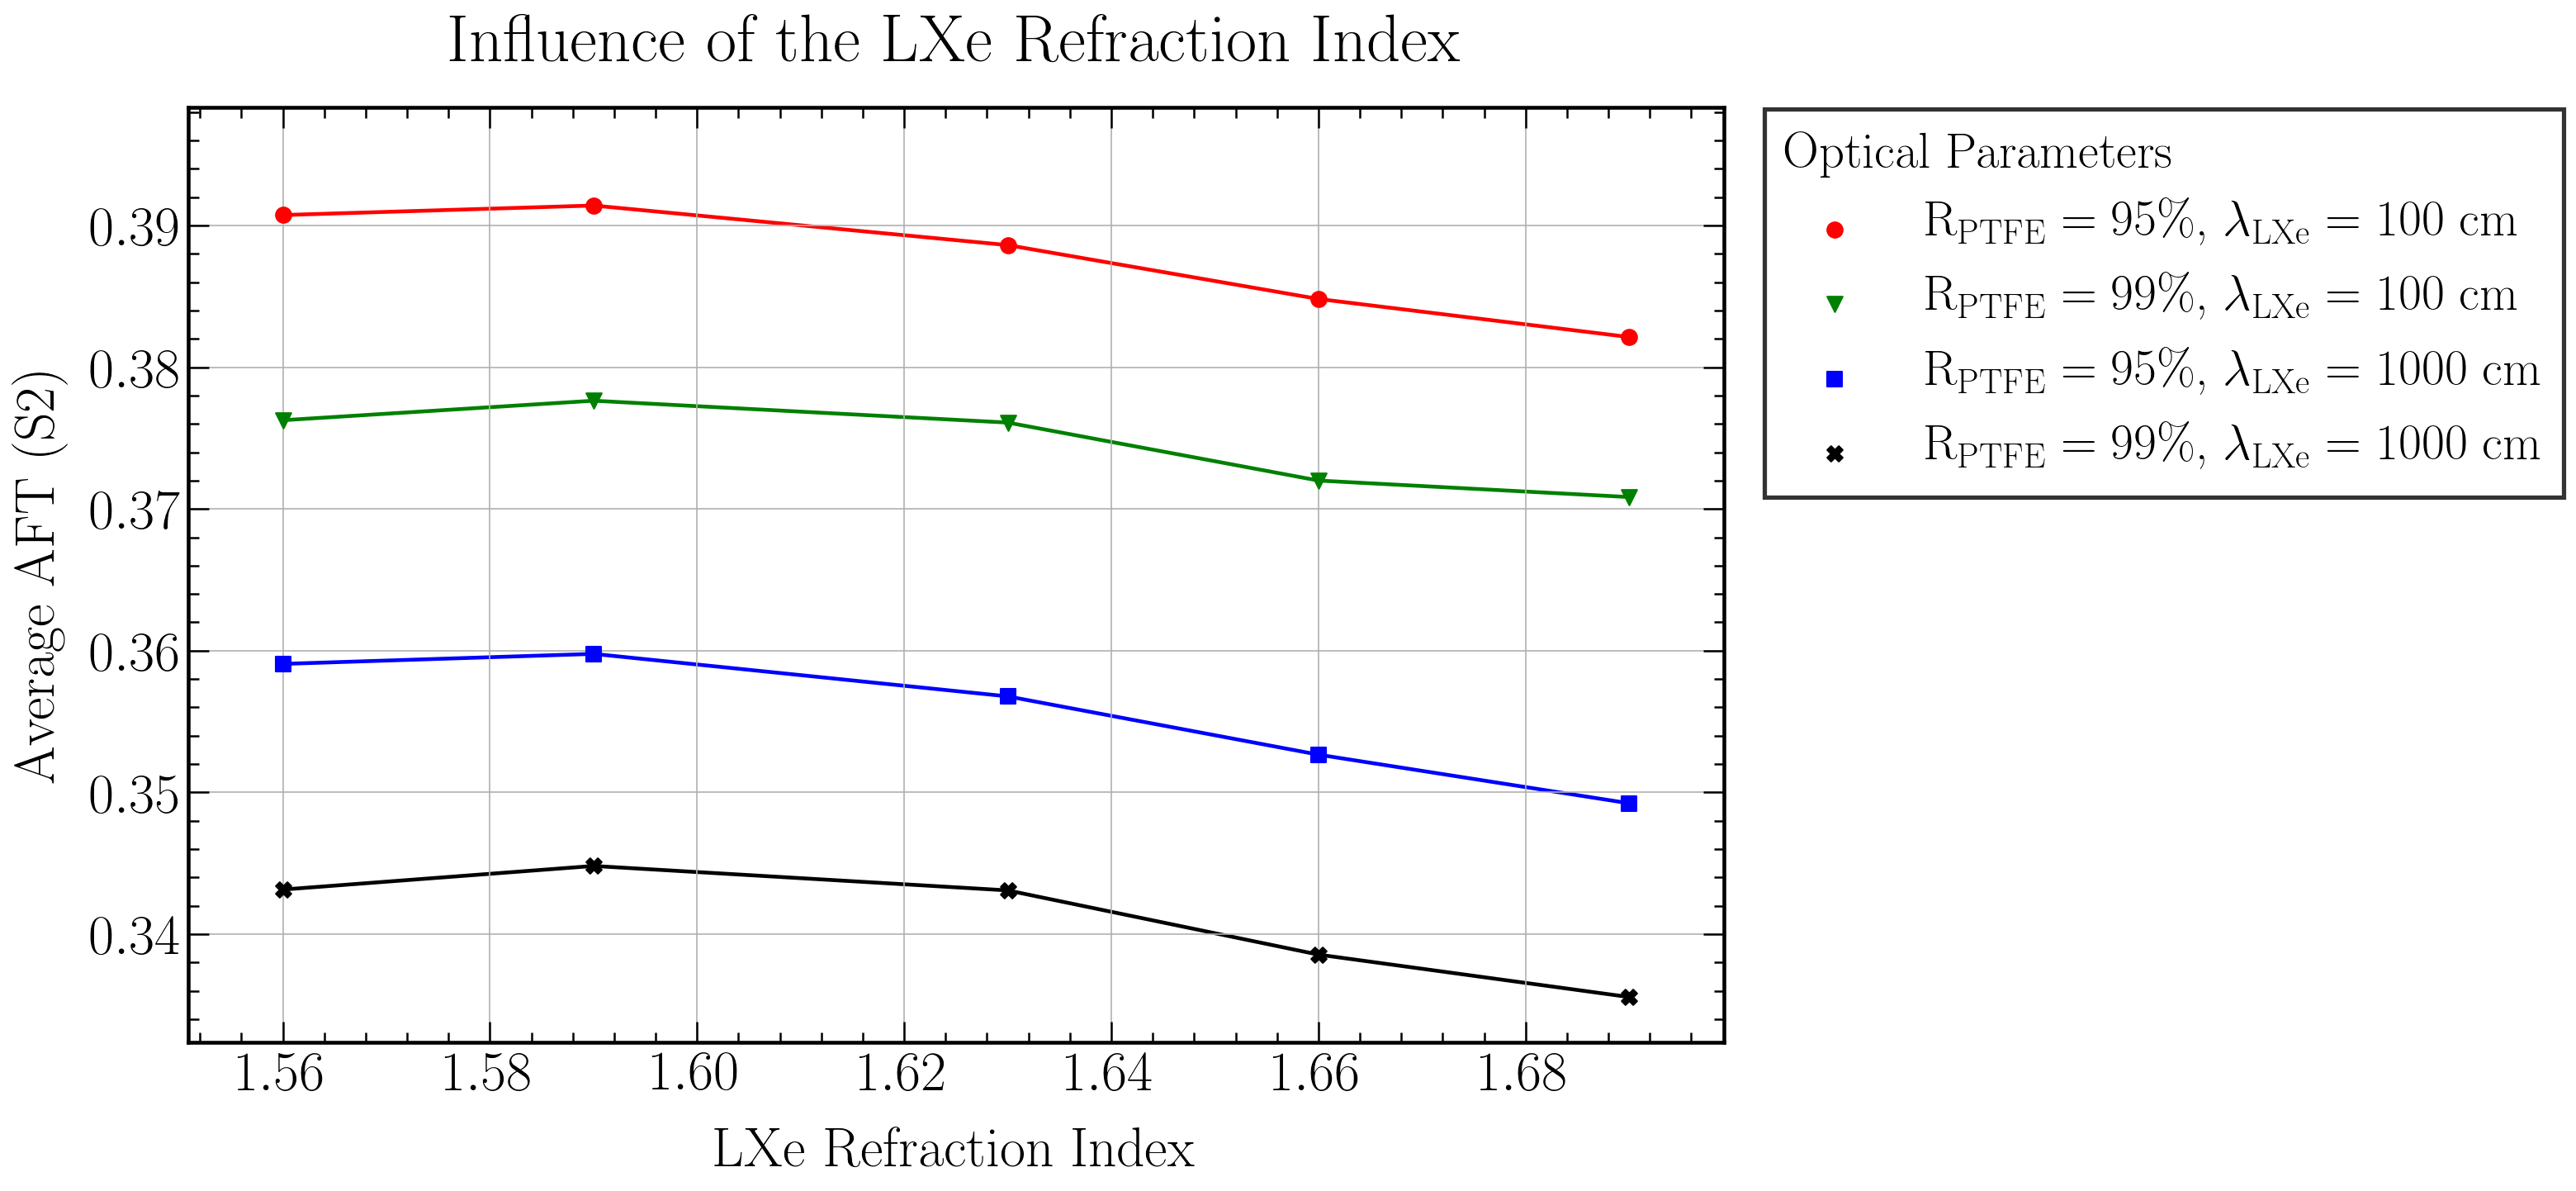

In [15]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xr = np.array(xr)[~np.isnan(np.array(yr))]
yr = np.array(yr)[~np.isnan(np.array(yr))]
yr = np.array([v for _,v in sorted(zip(xr,yr))])
xr = np.array(sorted(xr))
plt.plot(xr, yr, linewidth = 2.2, color = 'red', zorder=0)


x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xr = np.array(xr)[~np.isnan(np.array(yr))]
yr = np.array(yr)[~np.isnan(np.array(yr))]
yr = np.array([v for _,v in sorted(zip(xr,yr))])
xr = np.array(sorted(xr))
plt.plot(xr, yr, linewidth = 2.2, color = 'green', zorder=0)


x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xr = np.array(xr)[~np.isnan(np.array(yr))]
yr = np.array(yr)[~np.isnan(np.array(yr))]
yr = np.array([v for _,v in sorted(zip(xr,yr))])
xr = np.array(sorted(xr))
plt.plot(xr, yr, linewidth = 2.2, color = 'blue', zorder=0)


x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xr = np.array(xr)[~np.isnan(np.array(yr))]
yr = np.array(yr)[~np.isnan(np.array(yr))]
yr = np.array([v for _,v in sorted(zip(xr,yr))])
xr = np.array(sorted(xr))
plt.plot(xr, yr, linewidth = 2.2, color = 'black', zorder=0)


plt.xlabel('LXe Refraction Index', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average AFT (S2)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Refraction Index', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRefractionIndex_AFT_spline2_S2.png", bbox_inches='tight')
plt.show()

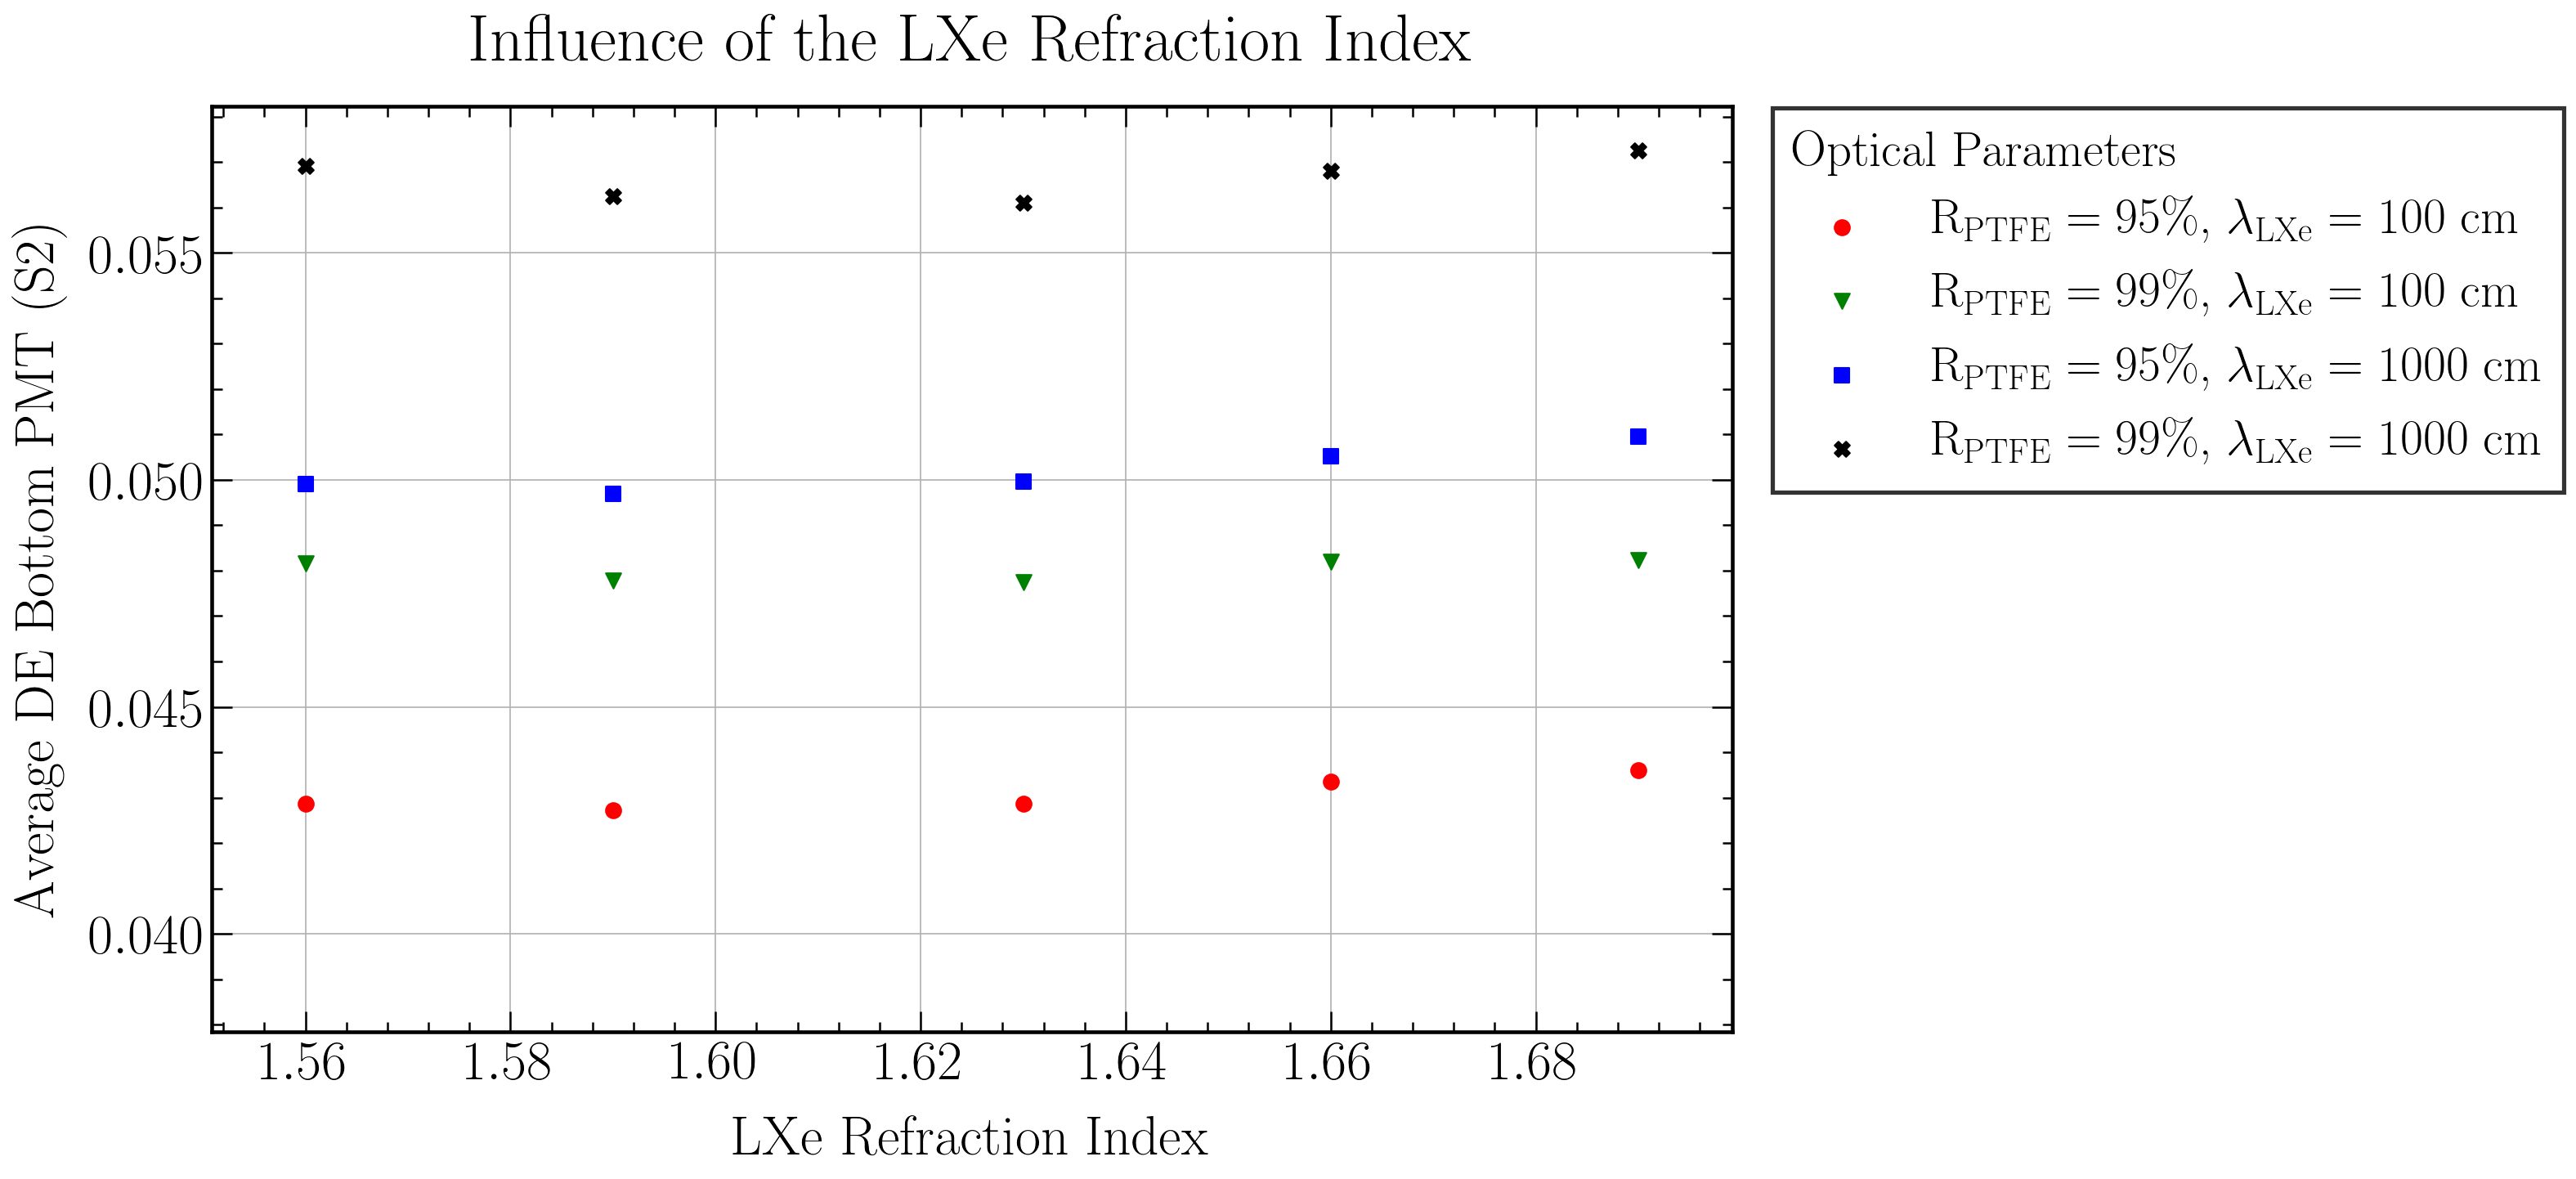

In [16]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["DE_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["DE_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["DE_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["DE_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

plt.xlabel('LXe Refraction Index', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average DE Bottom PMT (S2)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Refraction Index', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRefractionIndex_DE_Bottom_S2.png", bbox_inches='tight')
plt.show()

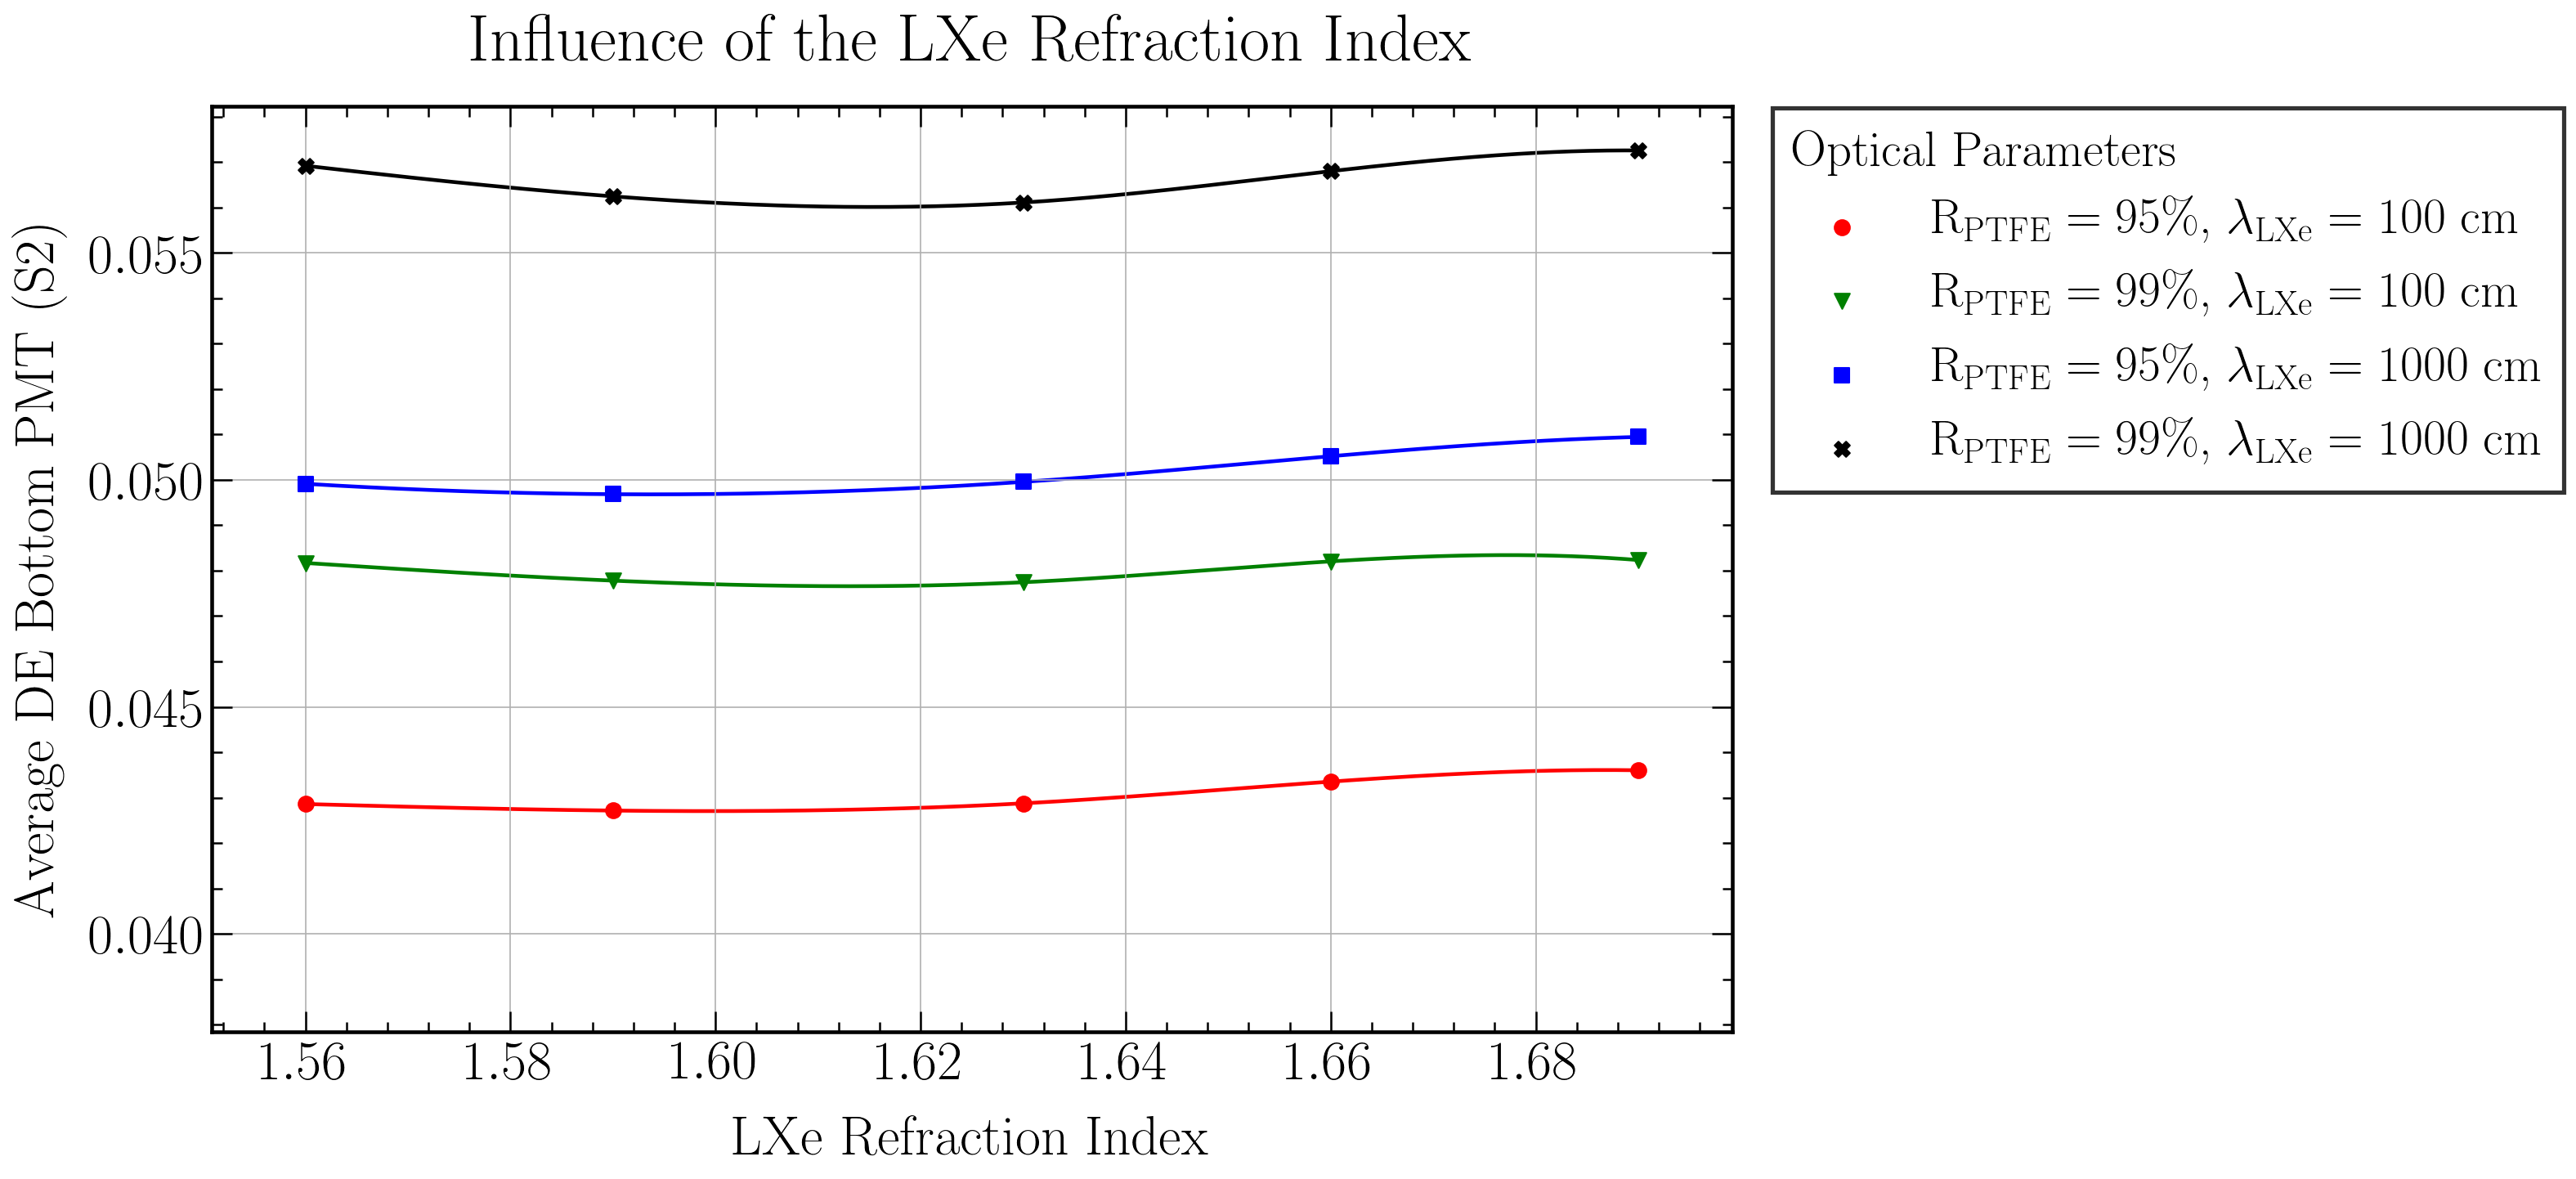

In [17]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["DE_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'red', zorder=0)

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["DE_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'green', zorder=0)

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["DE_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'blue', zorder=0)

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["DE_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'black', zorder=0)

plt.xlabel('LXe Refraction Index', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average DE Bottom PMT (S2)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Refraction Index', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRefractionIndex_DE_Bottom_spline_S2.png", bbox_inches='tight')
plt.show()

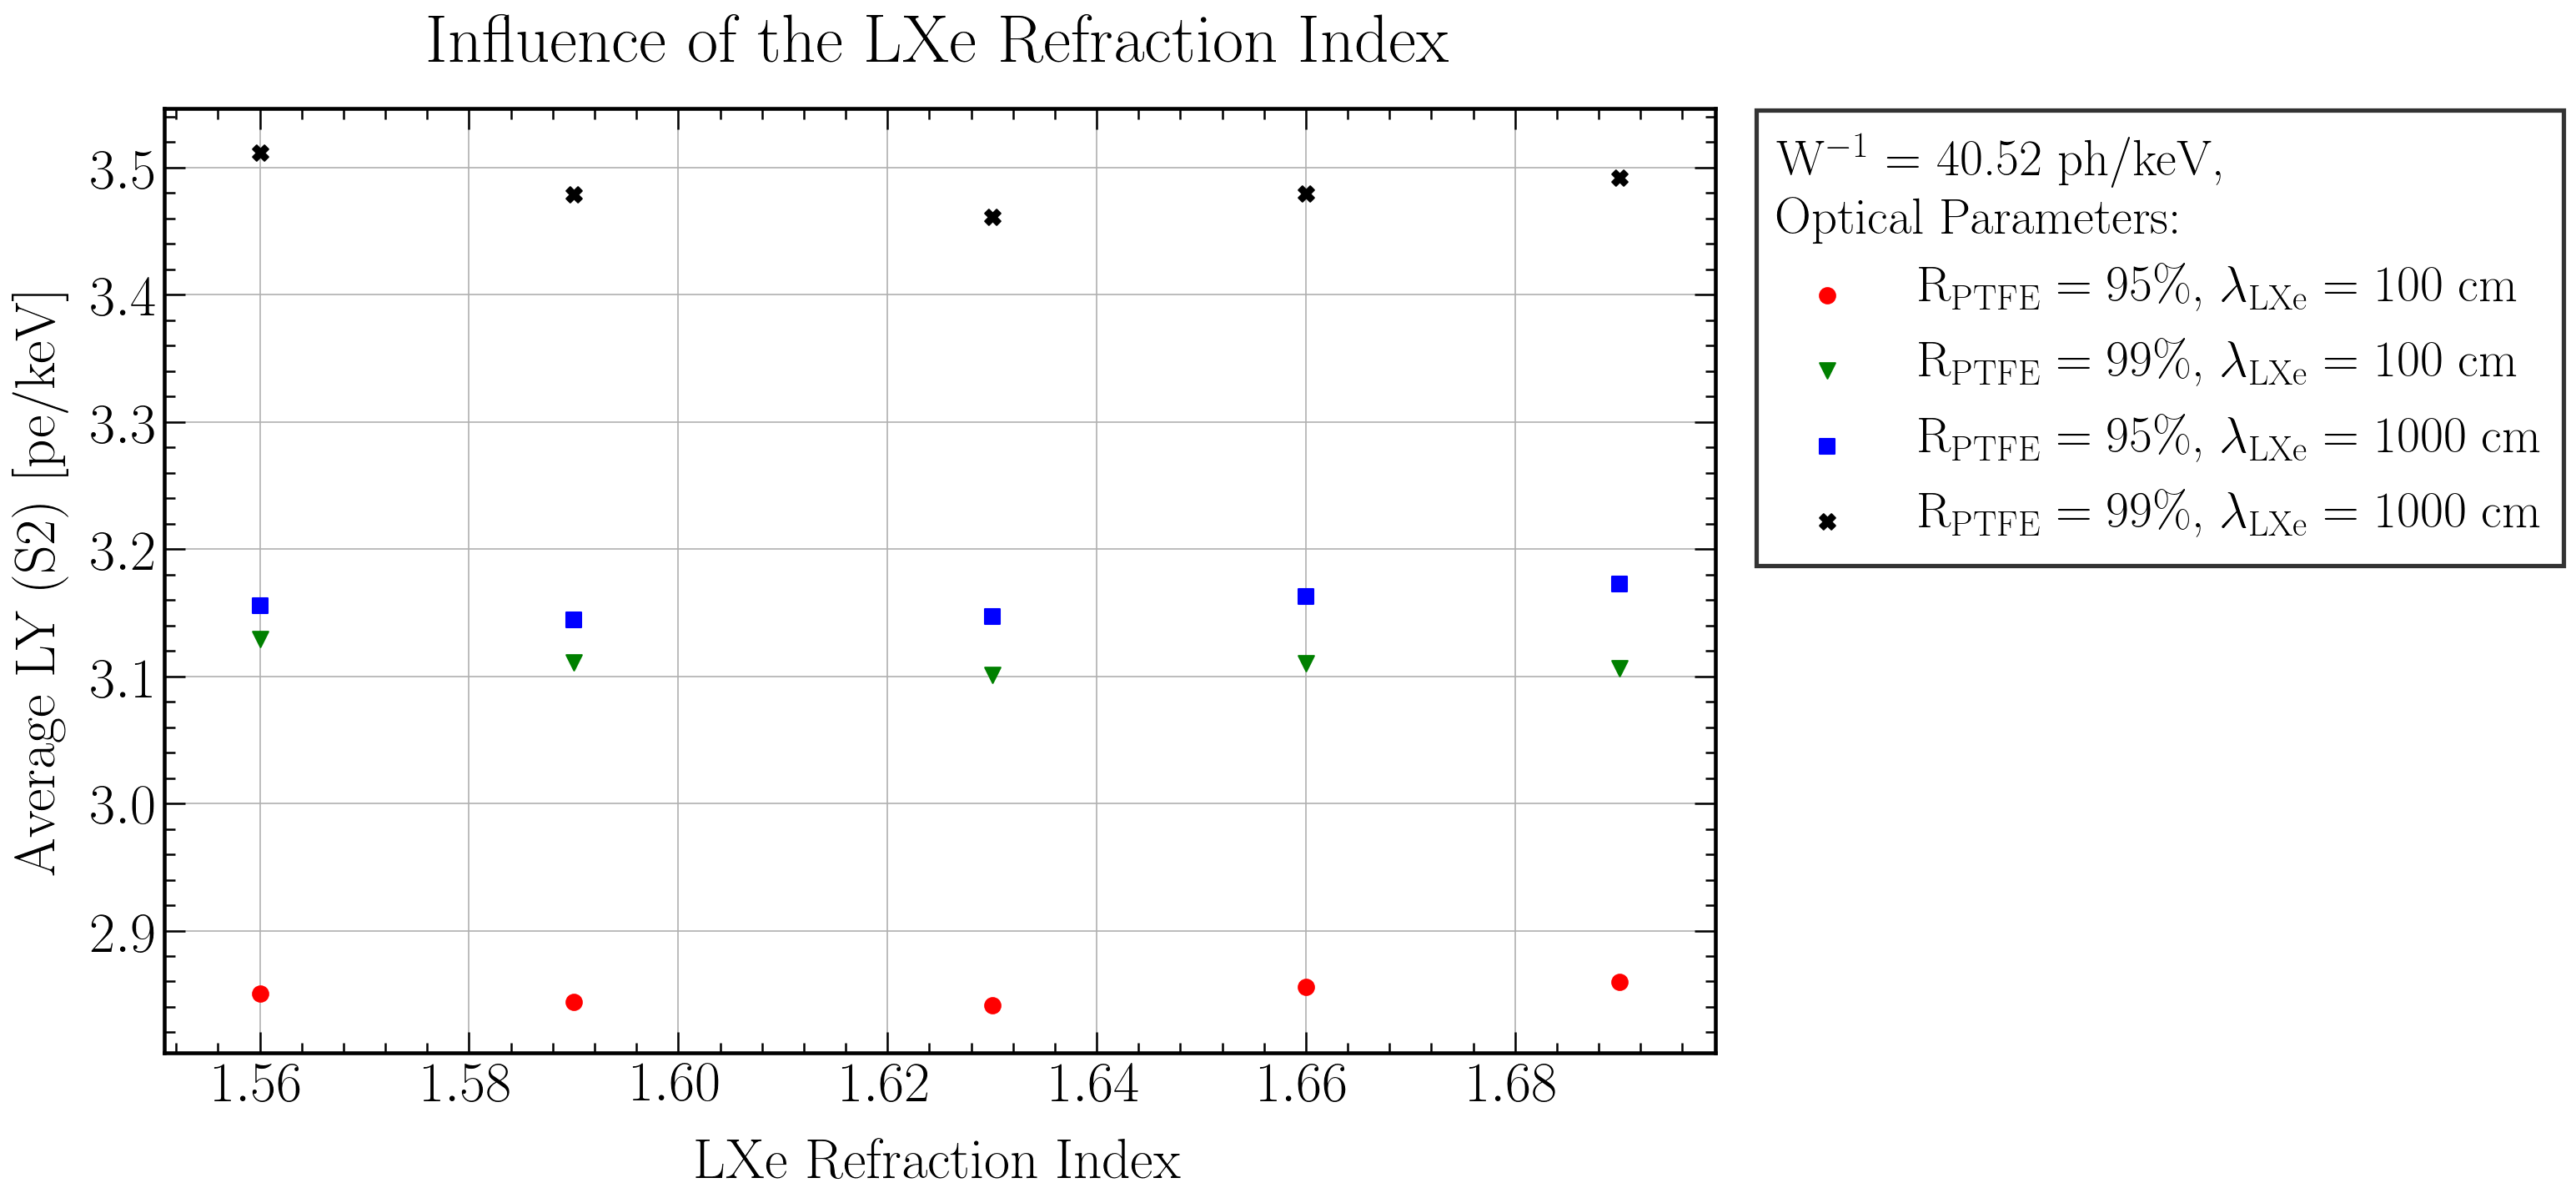

In [18]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LY_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LY_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

plt.xlabel('LXe Refraction Index', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY (S2) [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Refraction Index', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="W$^{-1}$ = "+str(round(1/W,2))+" ph/keV,\n"+"Optical Parameters:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRefractionIndex_LY_S2.png", bbox_inches='tight')
plt.show()

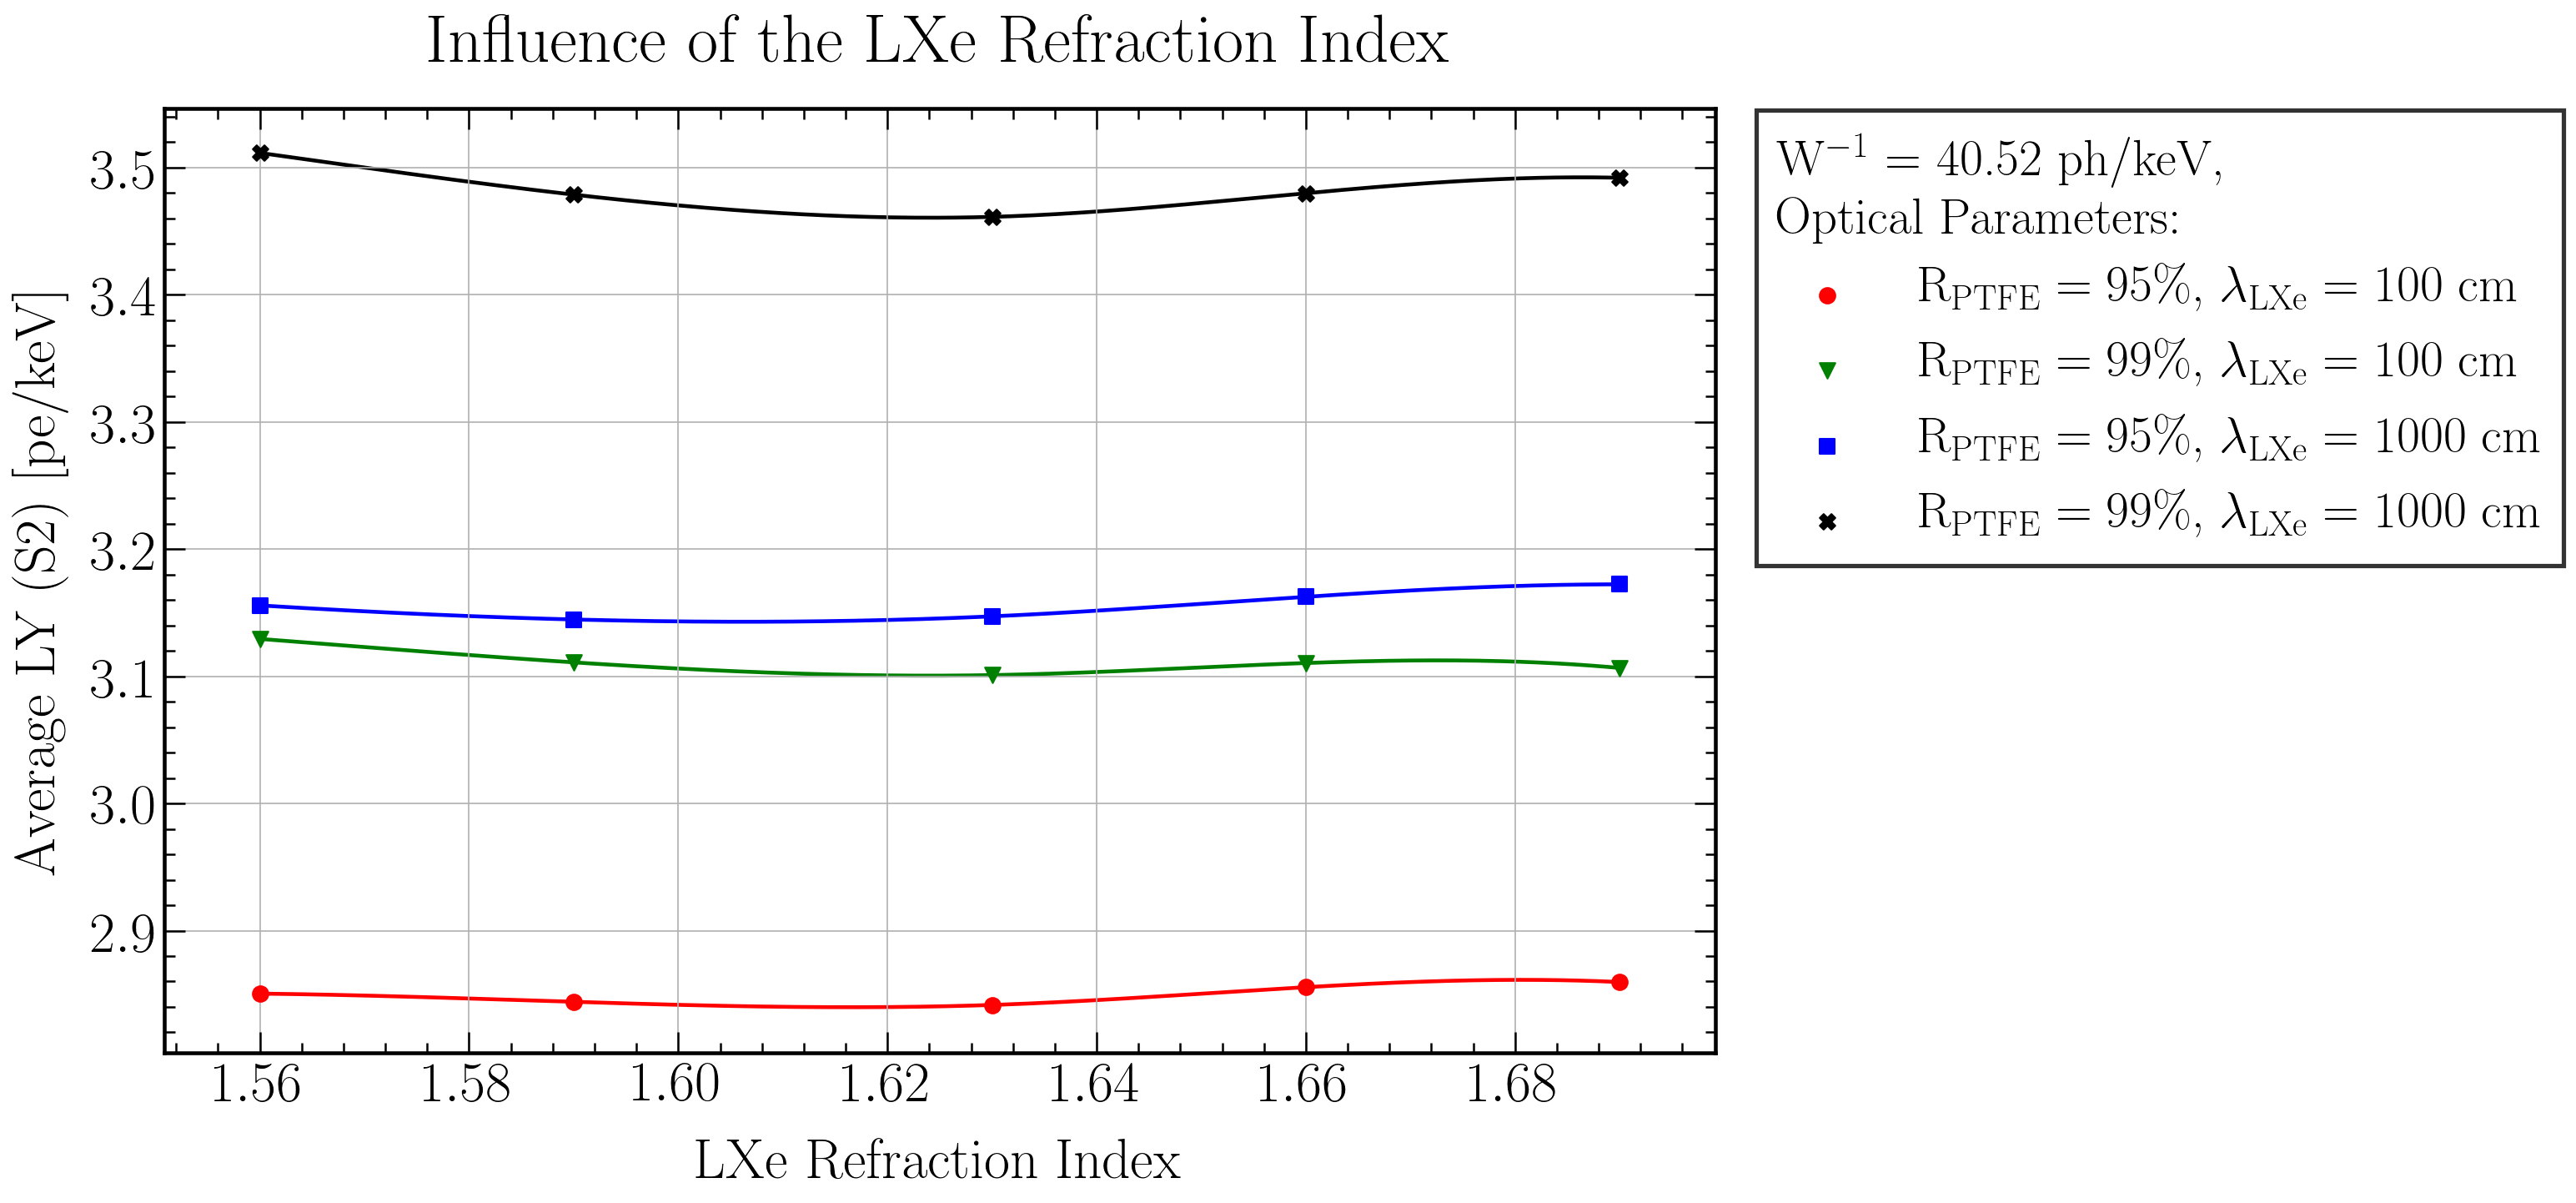

In [19]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LY_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'red', zorder=0)

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LY_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'green', zorder=0)

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'blue', zorder=0)

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'black', zorder=0)

plt.xlabel('LXe Refraction Index', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY (S2) [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Refraction Index', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="W$^{-1}$ = "+str(round(1/W,2))+" ph/keV,\n"+"Optical Parameters:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRefractionIndex_LY_spline_S2.png", bbox_inches='tight')
plt.show()

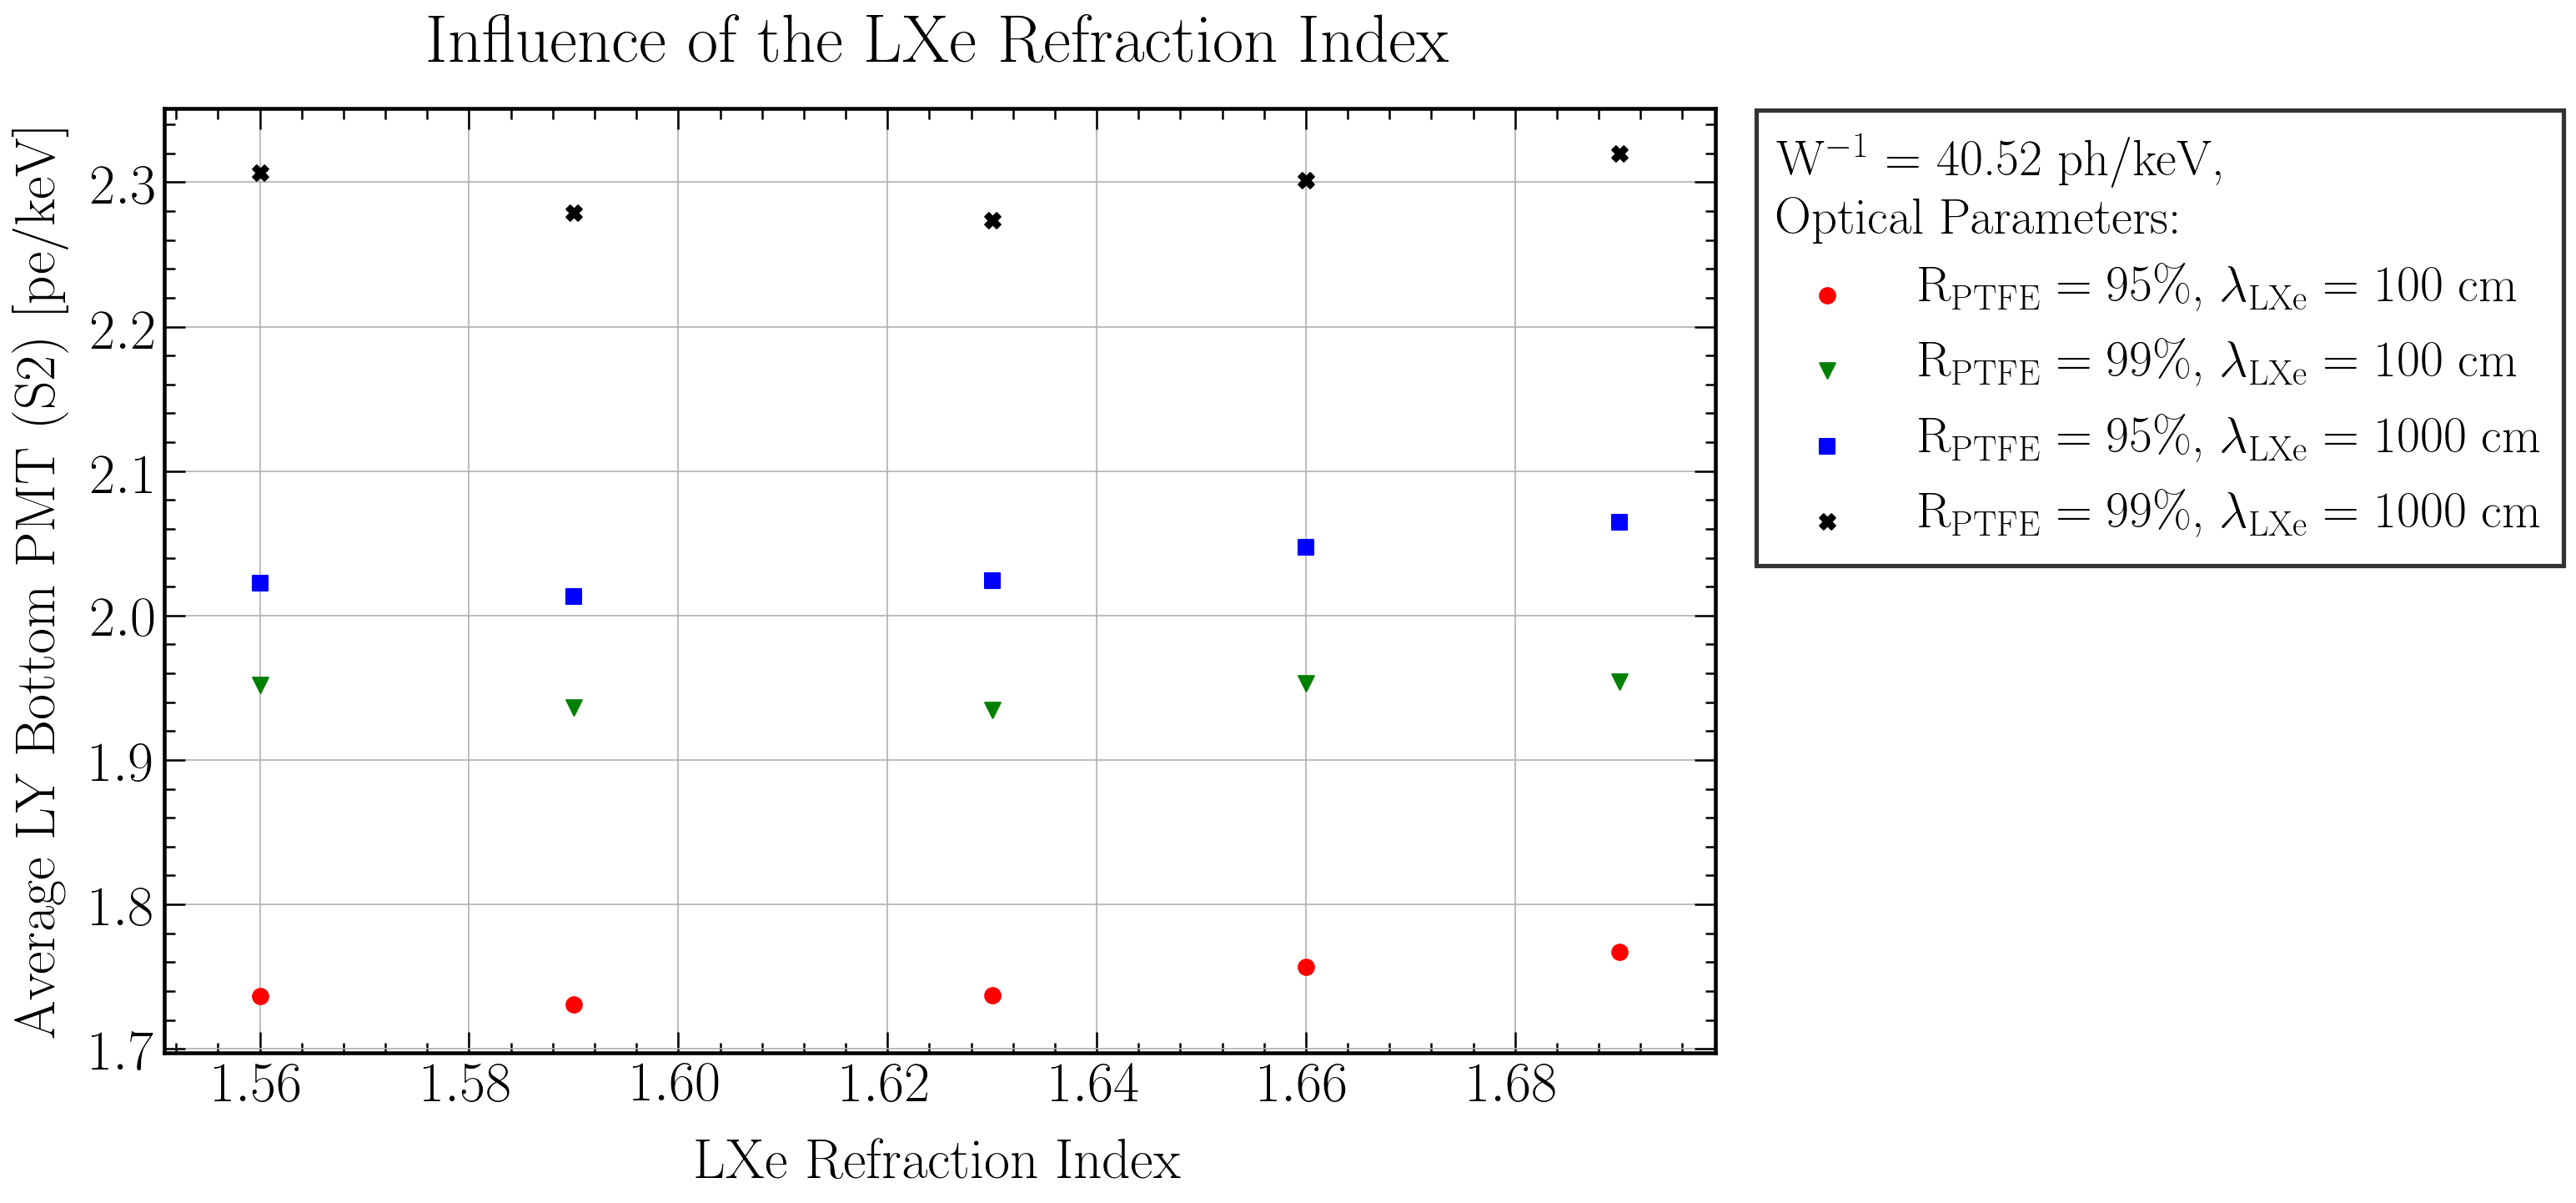

In [20]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LY_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LY_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

plt.xlabel('LXe Refraction Index', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY Bottom PMT (S2) [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Refraction Index', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="W$^{-1}$ = "+str(round(1/W,2))+" ph/keV,\n"+"Optical Parameters:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRefractionIndex_LY_Bottom_S2.png", bbox_inches='tight')
plt.show()

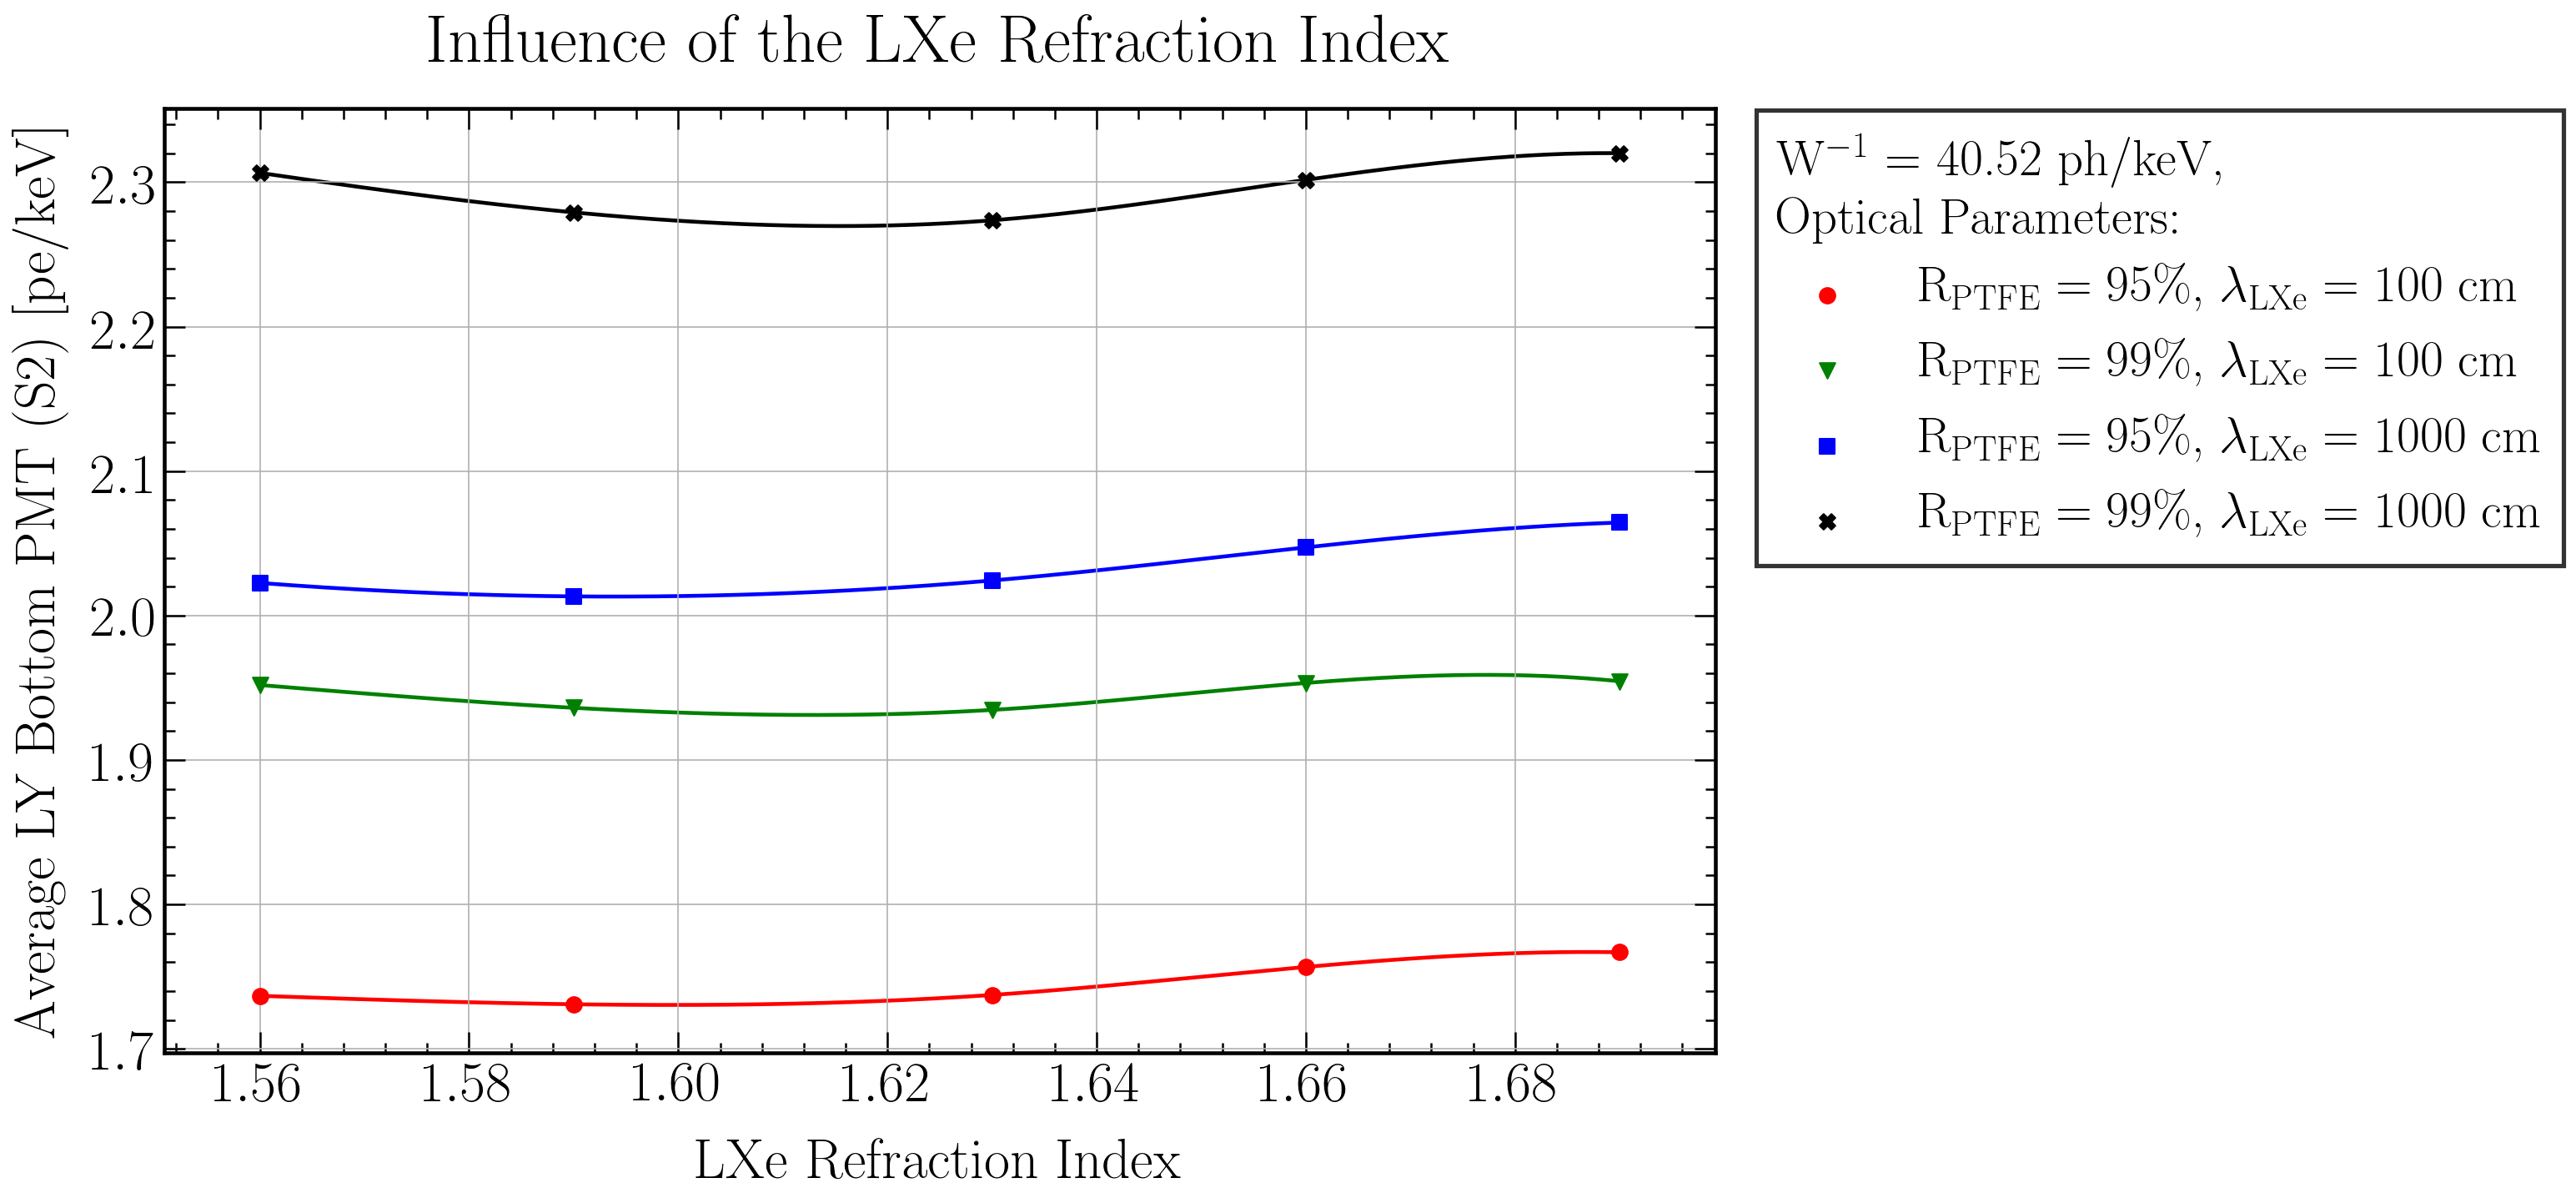

In [21]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LY_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'red', zorder=0)

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LY_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'green', zorder=0)

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'blue', zorder=0)

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'black', zorder=0)

plt.xlabel('LXe Refraction Index', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY Bottom PMT (S2) [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Refraction Index', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="W$^{-1}$ = "+str(round(1/W,2))+" ph/keV,\n"+"Optical Parameters:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRefractionIndex_LY_Bottom_spline_S2.png", bbox_inches='tight')
plt.show()

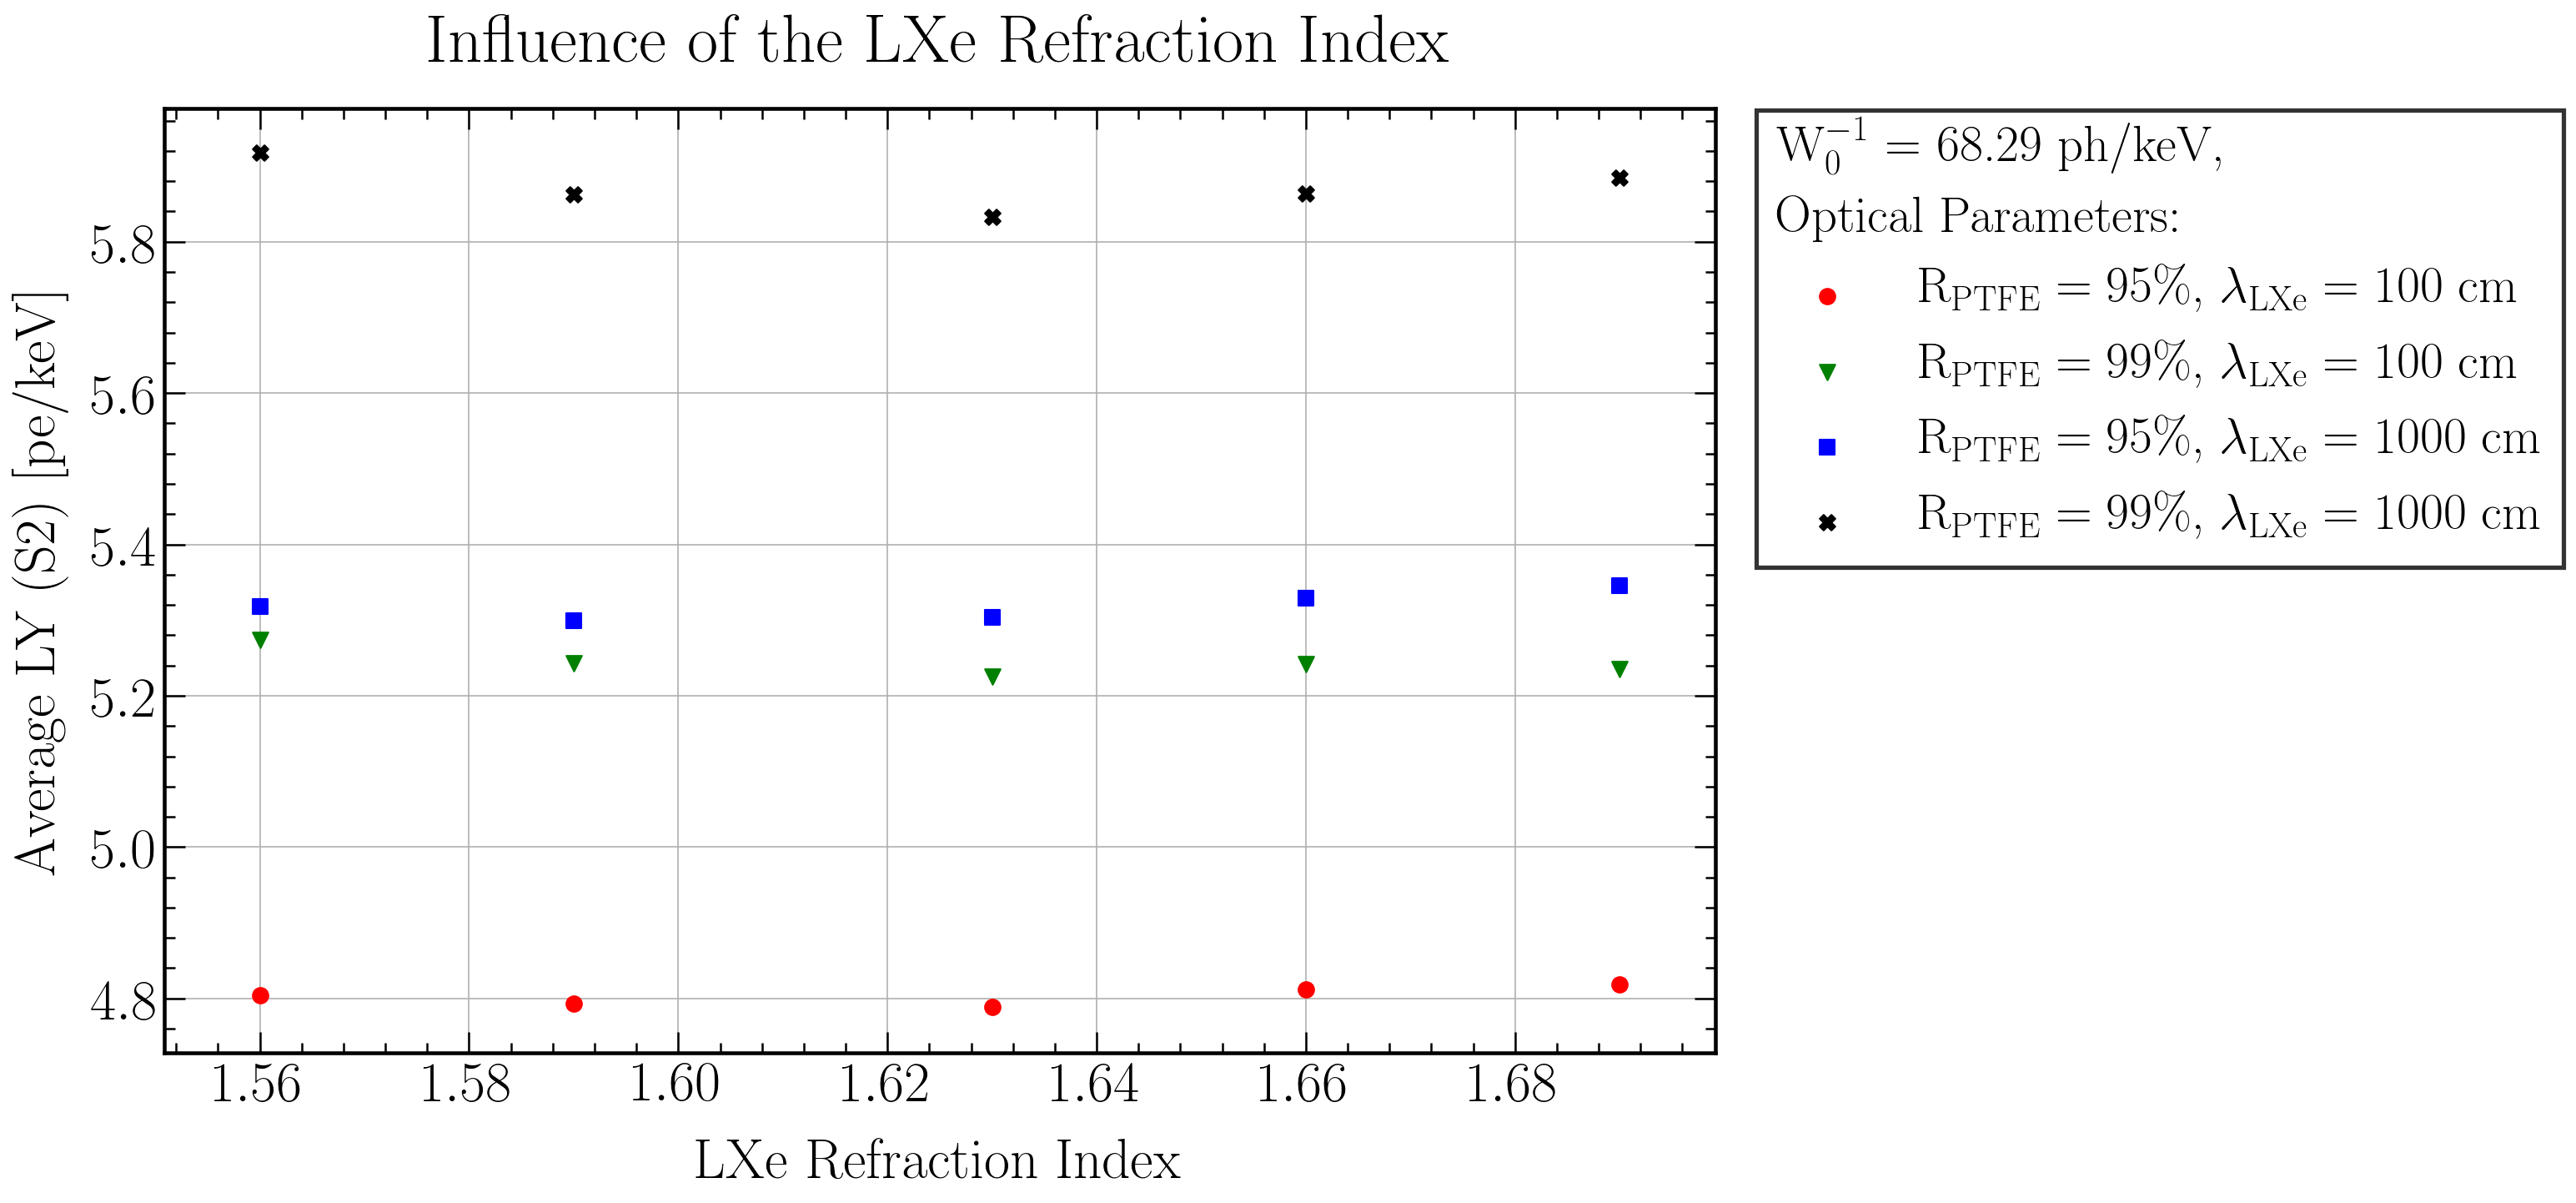

In [22]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

plt.xlabel('LXe Refraction Index', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY (S2) [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Refraction Index', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="W$_0^{-1}$ = "+str(round(1/W0,2))+" ph/keV,\nOptical Parameters:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRefractionIndex_LY0_S2.png", bbox_inches='tight')
plt.show()

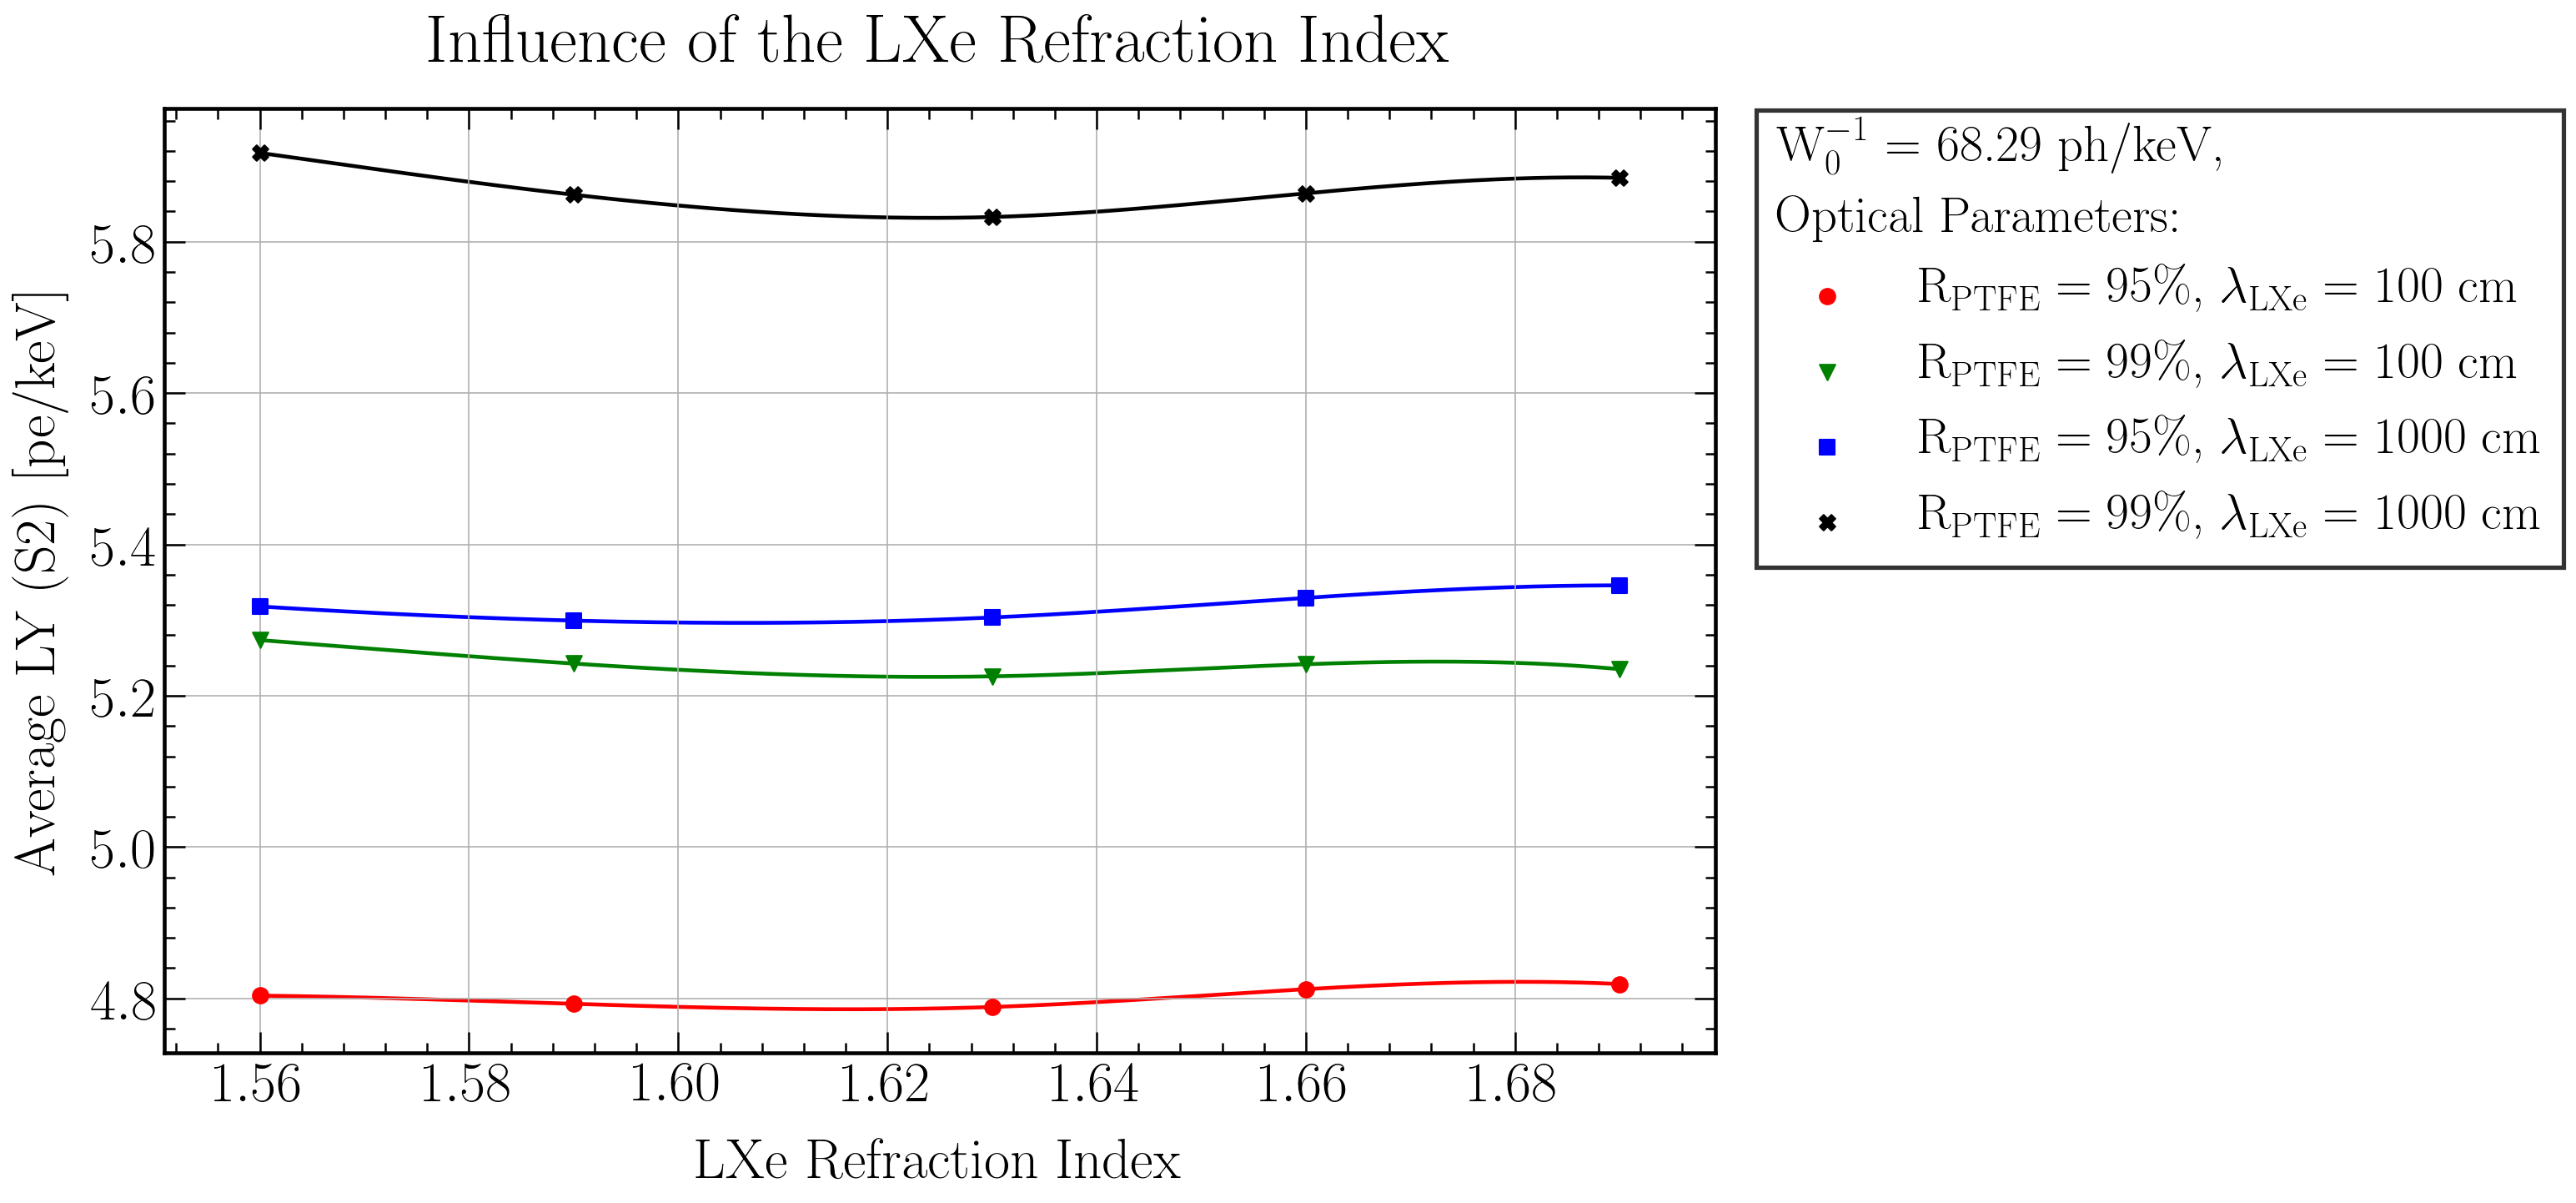

In [23]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'red', zorder=0)

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'green', zorder=0)

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'blue', zorder=0)

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'black', zorder=0)

plt.xlabel('LXe Refraction Index', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY (S2) [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Refraction Index', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="W$_0^{-1}$ = "+str(round(1/W0,2))+" ph/keV,\nOptical Parameters:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRefractionIndex_LY0_spline_S2.png", bbox_inches='tight')
plt.show()

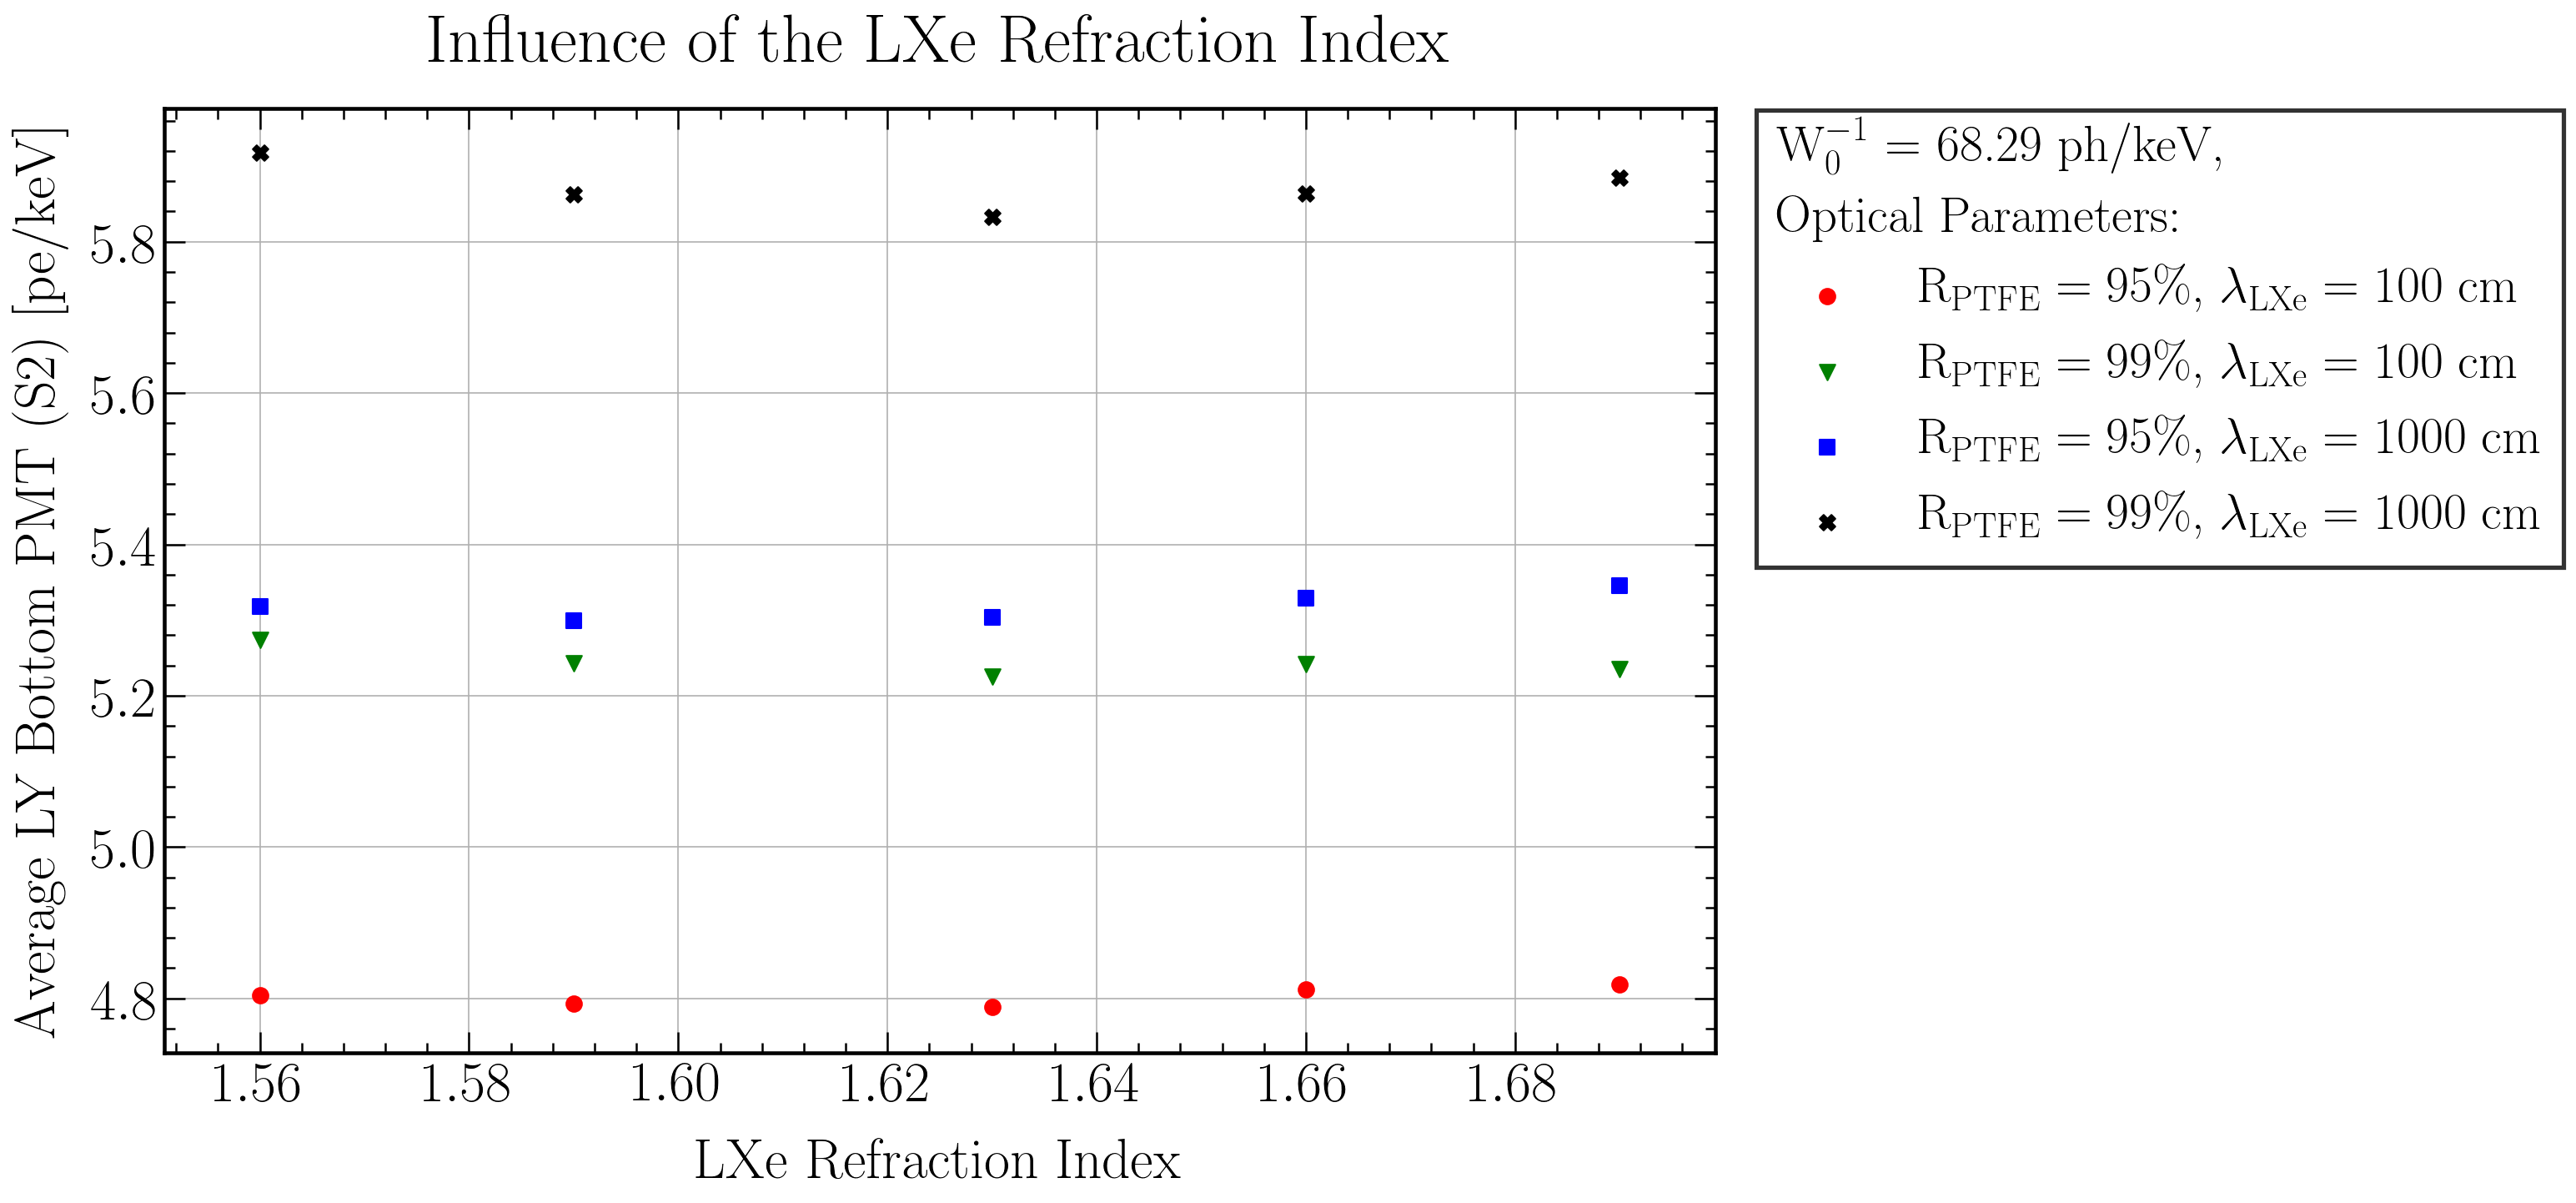

In [24]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

plt.xlabel('LXe Refraction Index', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY Bottom PMT (S2) [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Refraction Index', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="W$_0^{-1}$ = "+str(round(1/W0,2))+" ph/keV,\nOptical Parameters:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRefractionIndex_LY0_Bottom_S2.png", bbox_inches='tight')
plt.show()

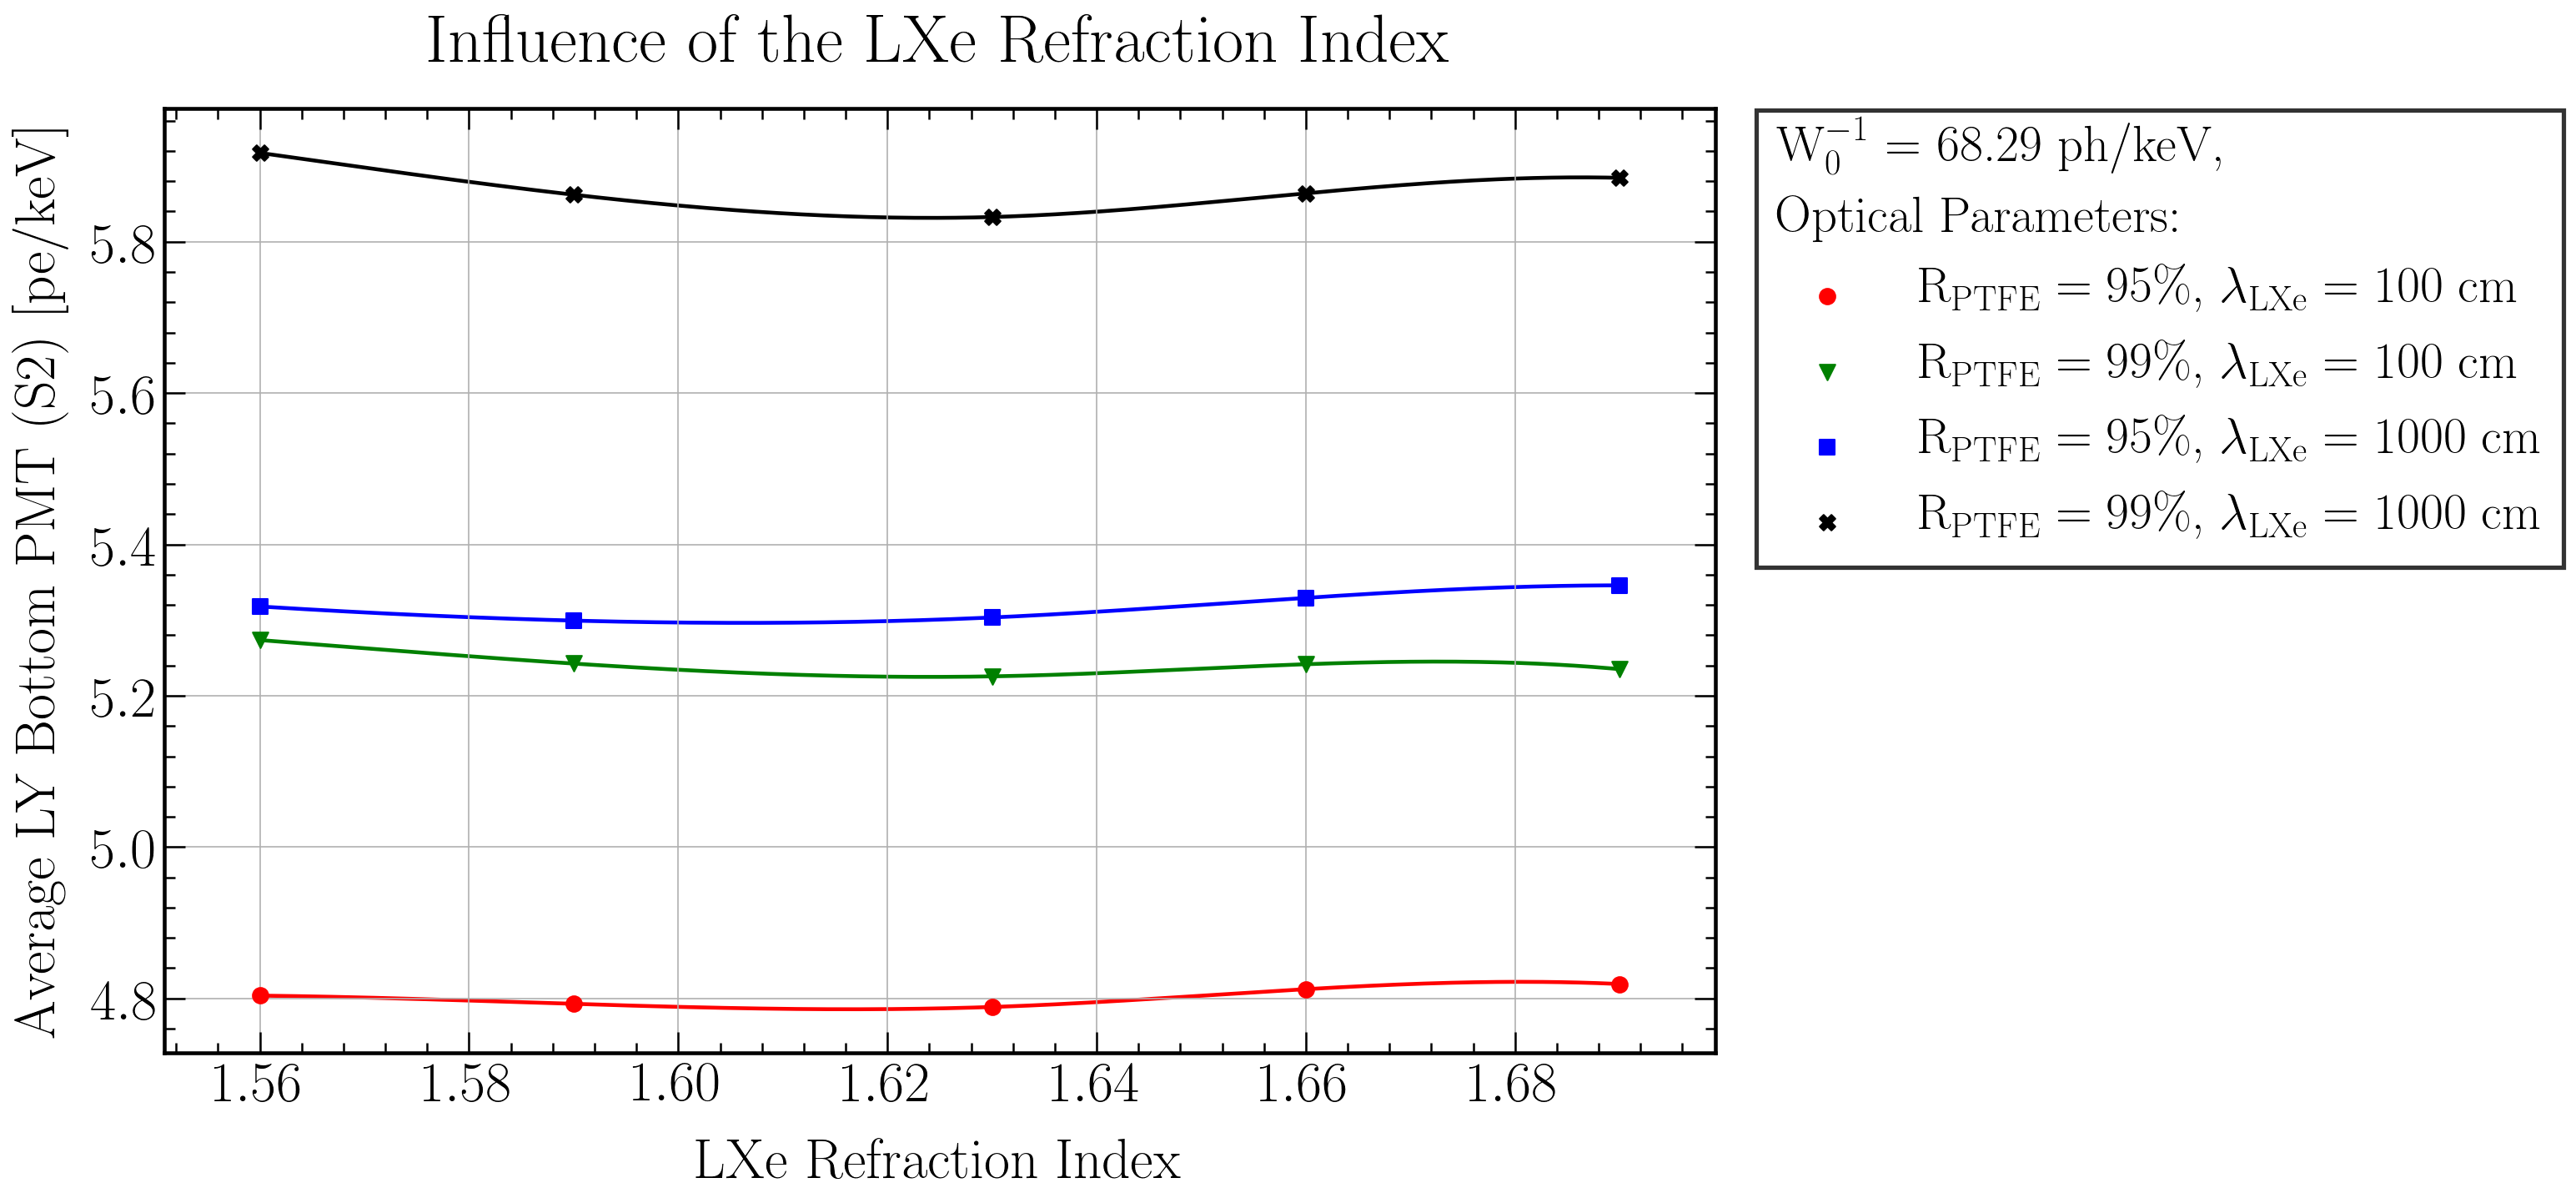

In [25]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'red', zorder=0)

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'green', zorder=0)

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'blue', zorder=0)

x = opticals["LXeRefractionIndex"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'black', zorder=0)

plt.xlabel('LXe Refraction Index', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY Bottom PMT (S2) [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Refraction Index', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="W$_0^{-1}$ = "+str(round(1/W0,2))+" ph/keV,\nOptical Parameters:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRefractionIndex_LY0_Bottom_spline_S2.png", bbox_inches='tight')
plt.show()